In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import Timestamp
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 4) 


plt.rcParams["figure.dpi"] = 400

raw = pd.read_csv("USCurves.csv")

MONTH = 'MONTH'
YEAR = 'YEAR'
MONTHS_IN_YEAR = 12

## Data Preprocessing

We will be working with a Pandas DataFrame. Columns are `float` with the maturity, and rows are different observations, indexed by a `pd.Timestamp` object

In [39]:
column_mutations = {}
for i in range(1, len(raw.columns)-1):
    x = raw.columns[i]
    if YEAR in x or MONTH in x:
        time_str = x[3:]
        if YEAR in x:
            time_str = time_str.split(YEAR)[0]
            time = float(time_str)
        elif MONTH in x:
            time_str = time_str.split(MONTH)[0]
            time_raw = float(time_str) / MONTHS_IN_YEAR
            time = round(time_raw, 2)
        else:
            raise RuntimeError("This branch should never execute")


    column_mutations[raw.columns[i]] = time

new_columns = raw.rename(columns=column_mutations)
yield_curves = new_columns.set_index(pd.to_datetime(new_columns["date"])).drop(["date", "BC_30YEARDISPLAY"], axis=1)
yield_curves.drop(columns=20, inplace=True)

## Visualising the raw data

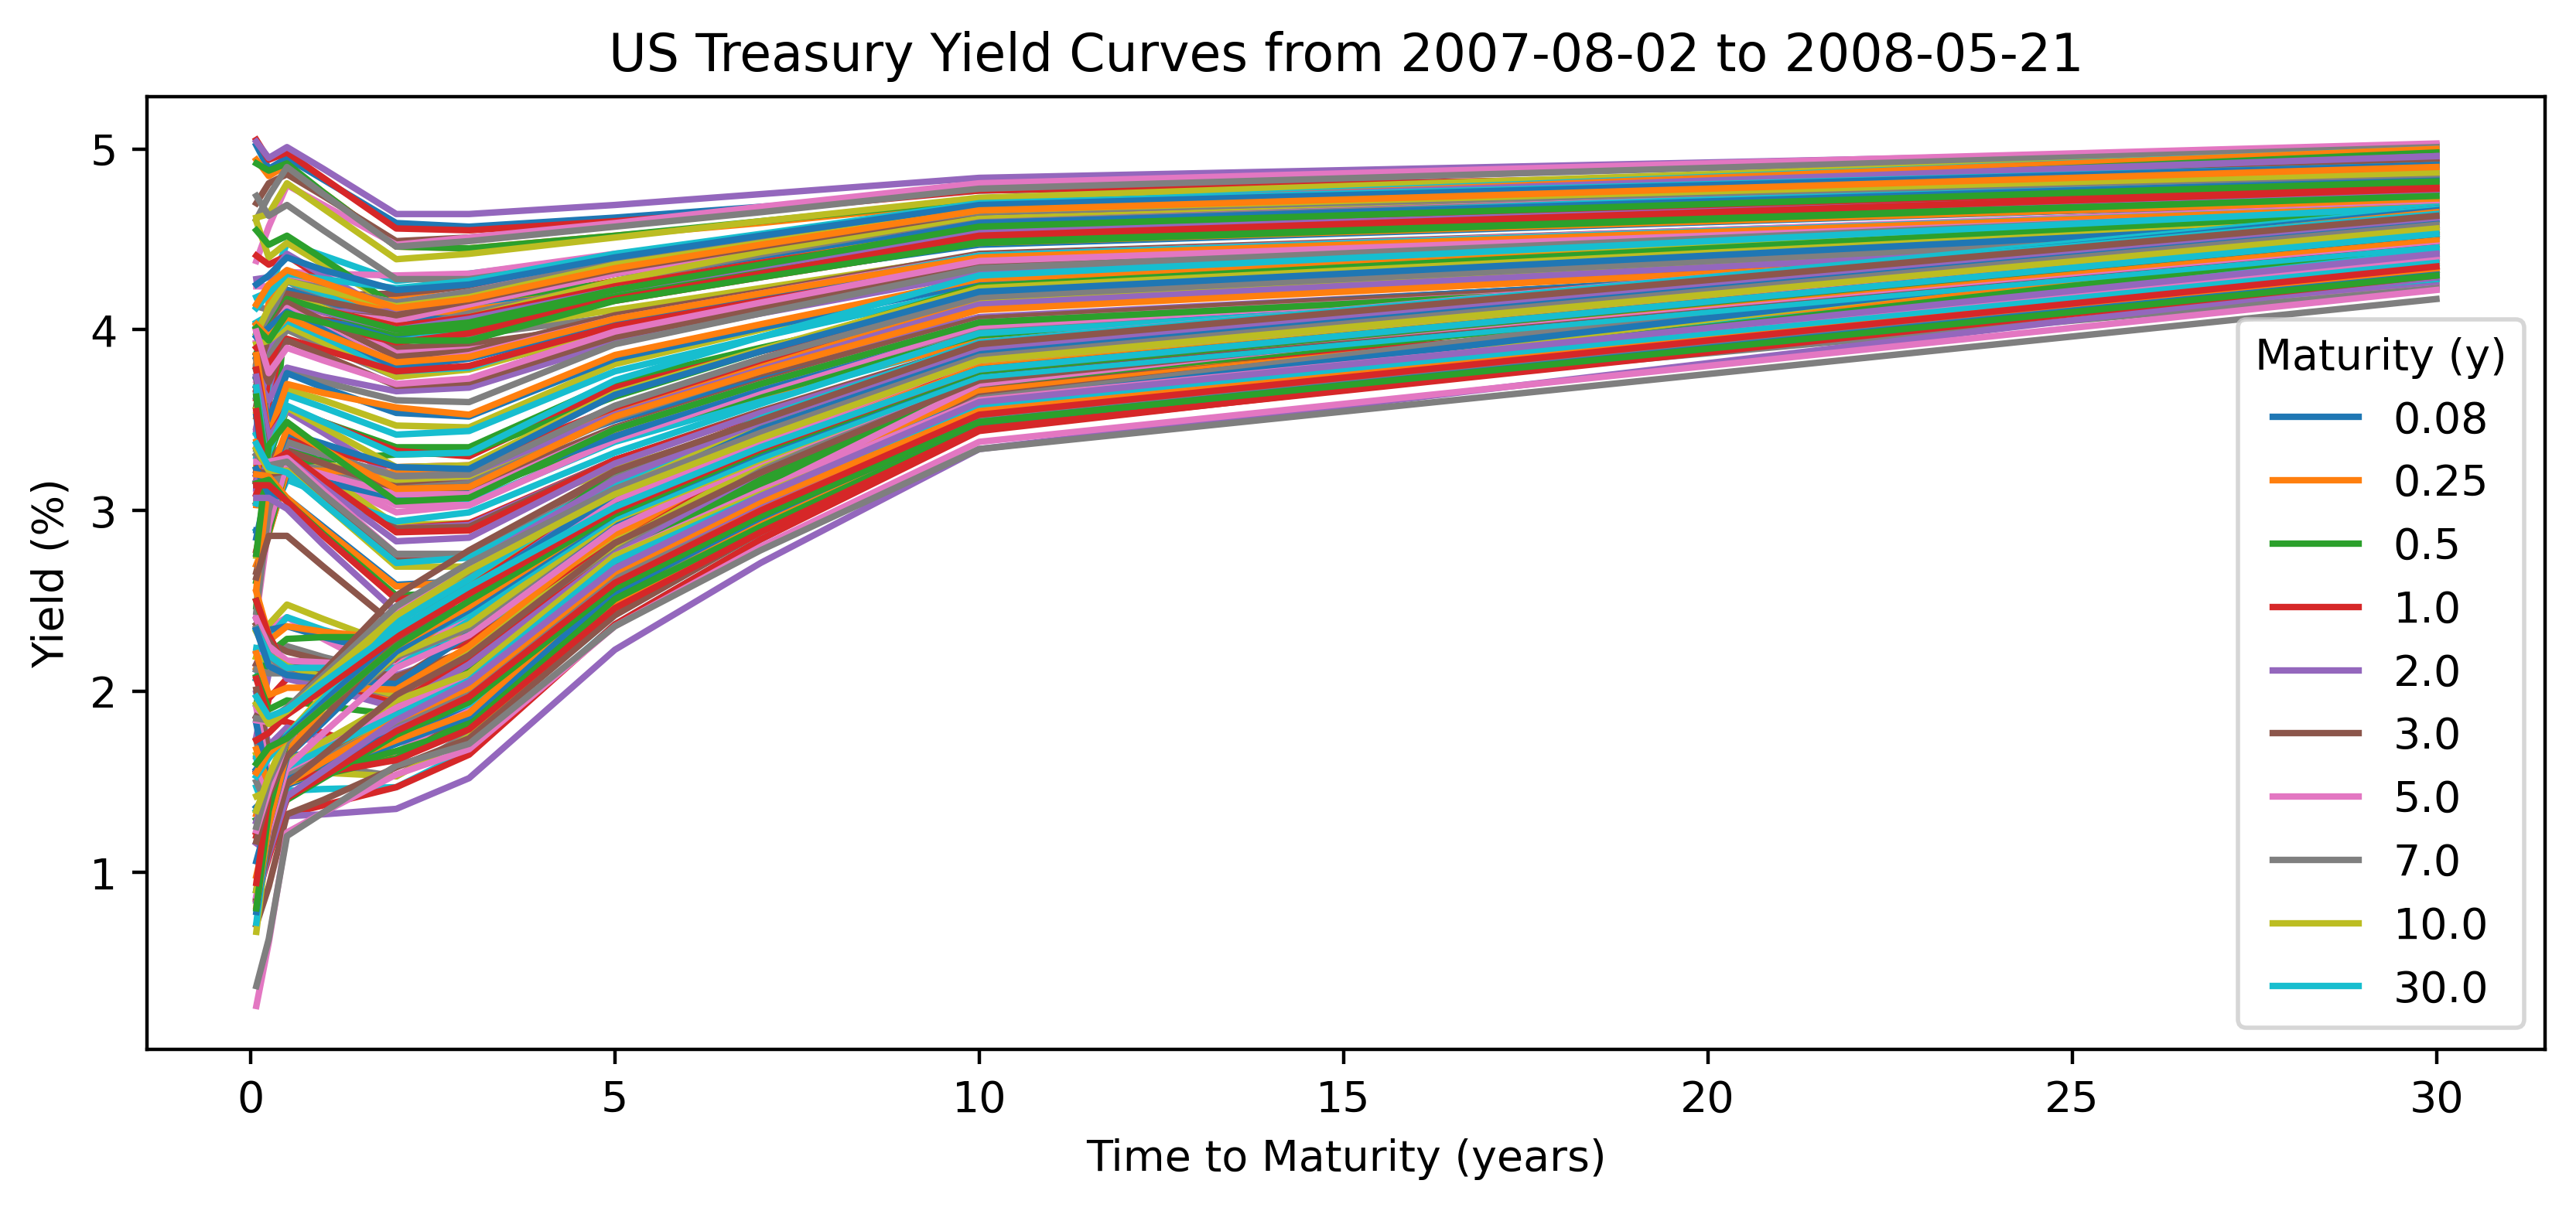

In [40]:
start_idx = 4400
num_curves = 200
end_idx = start_idx + num_curves

start_date: Timestamp = yield_curves.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = yield_curves.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(yield_curves.iloc[start_idx:end_idx].T)
plt.title(f"US Treasury Yield Curves from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.show()

## Initial Exploration

Correlation plot gives us a good way to start on the structure of the data.

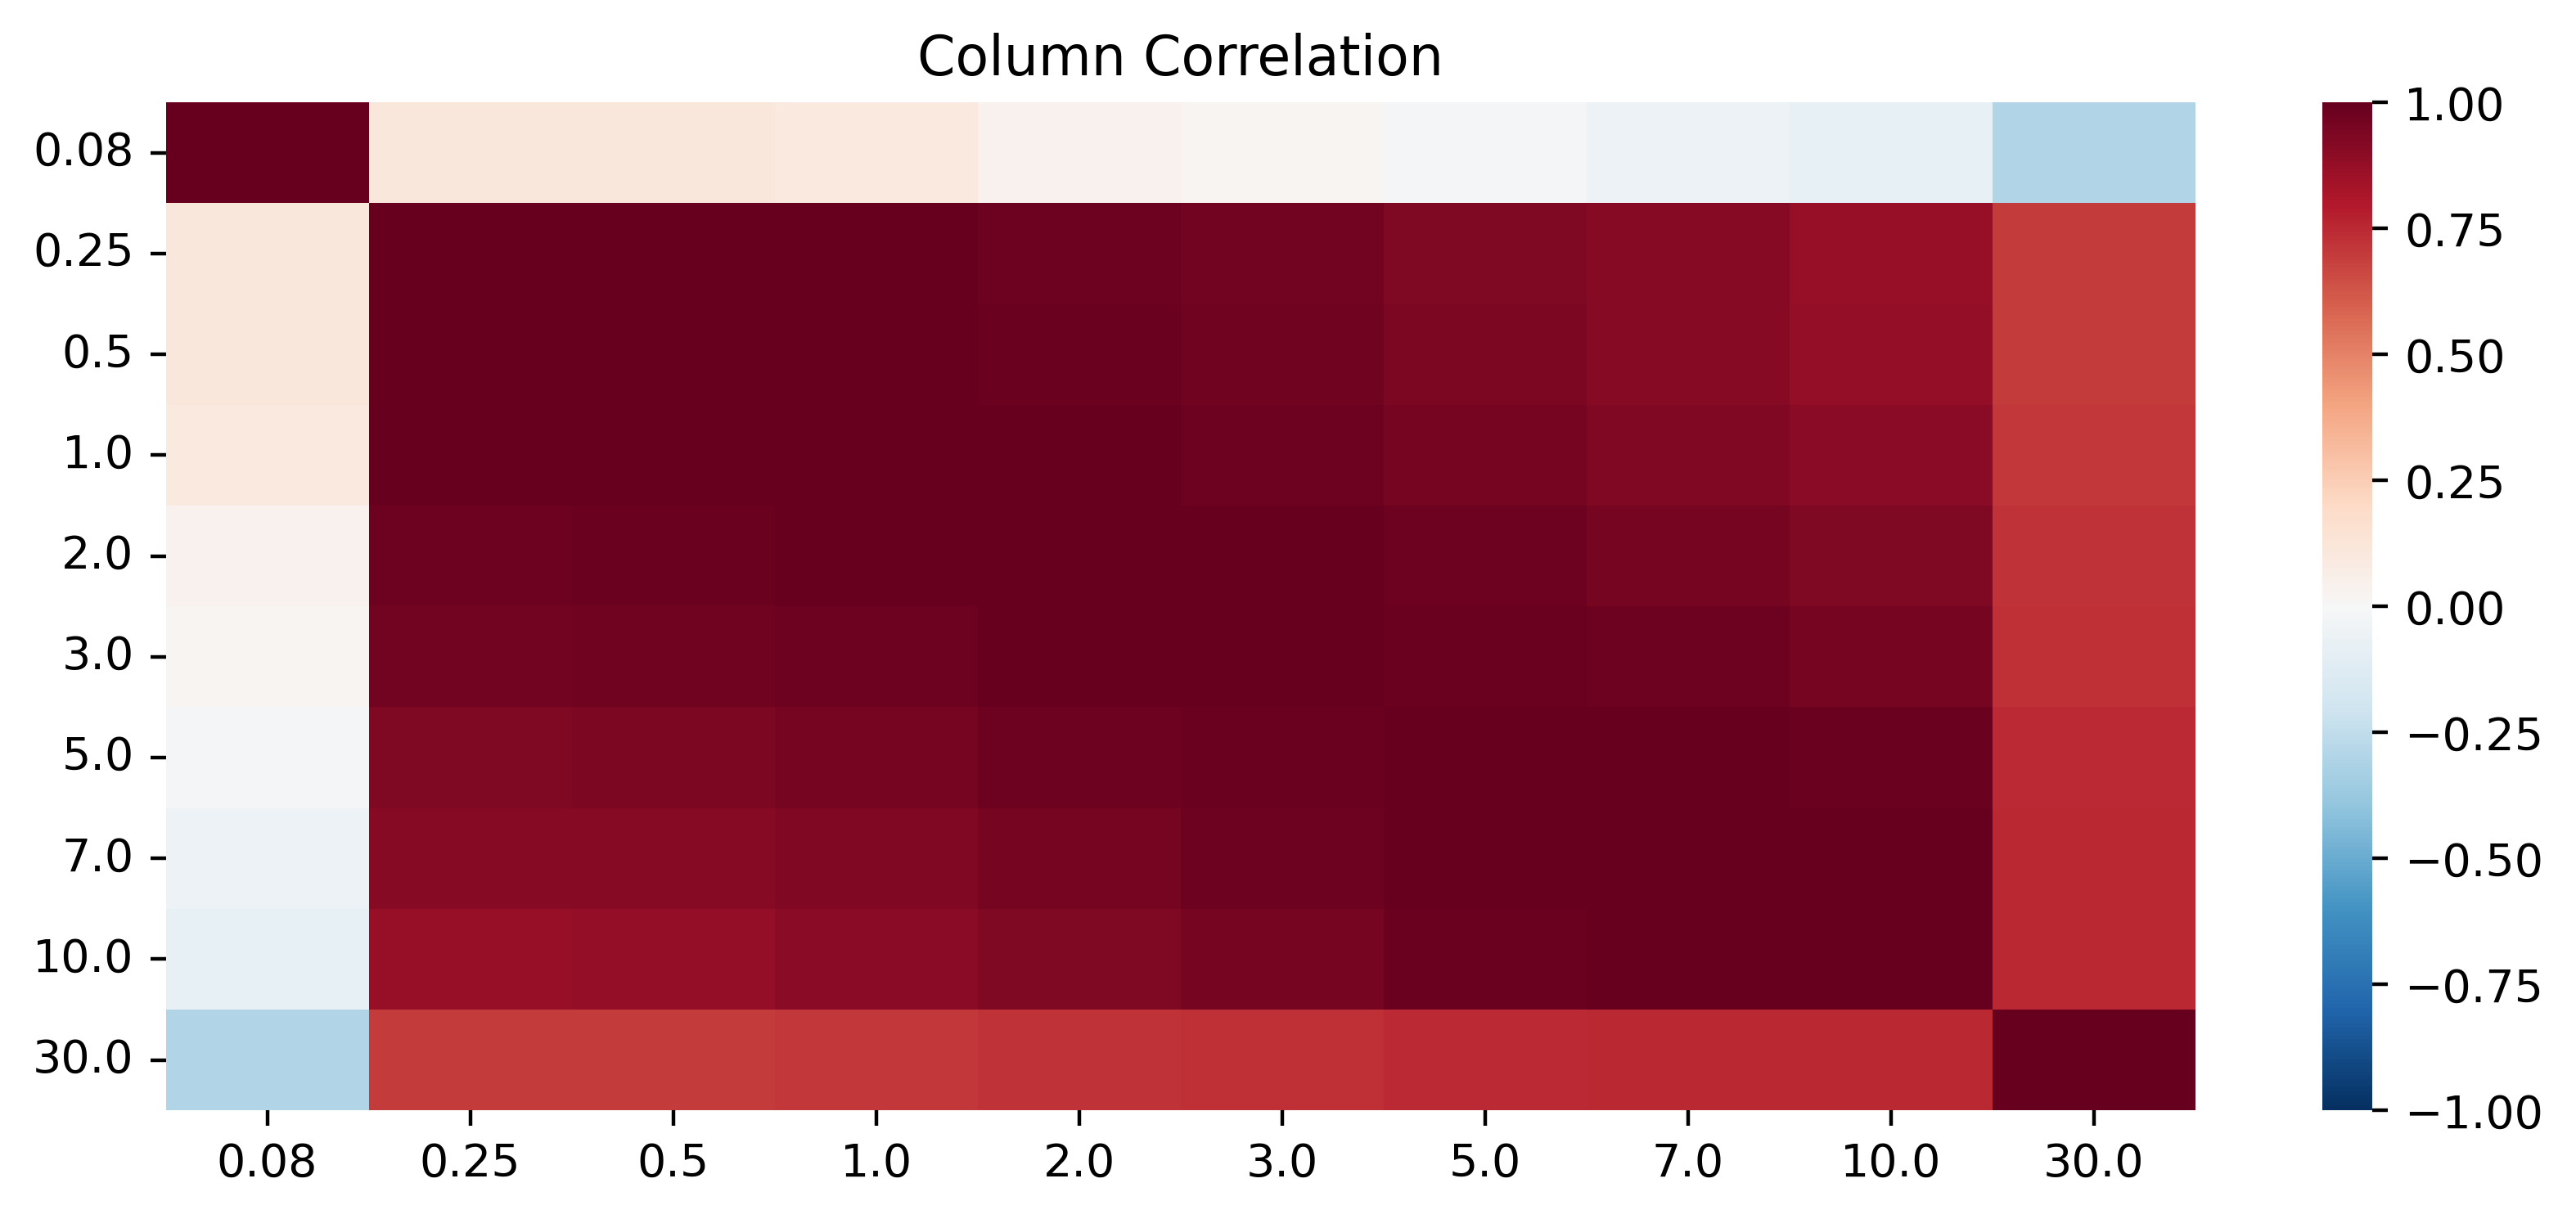

In [41]:
sns.heatmap(yield_curves.select_dtypes(include="number").corr(), cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Column Correlation")
plt.show()

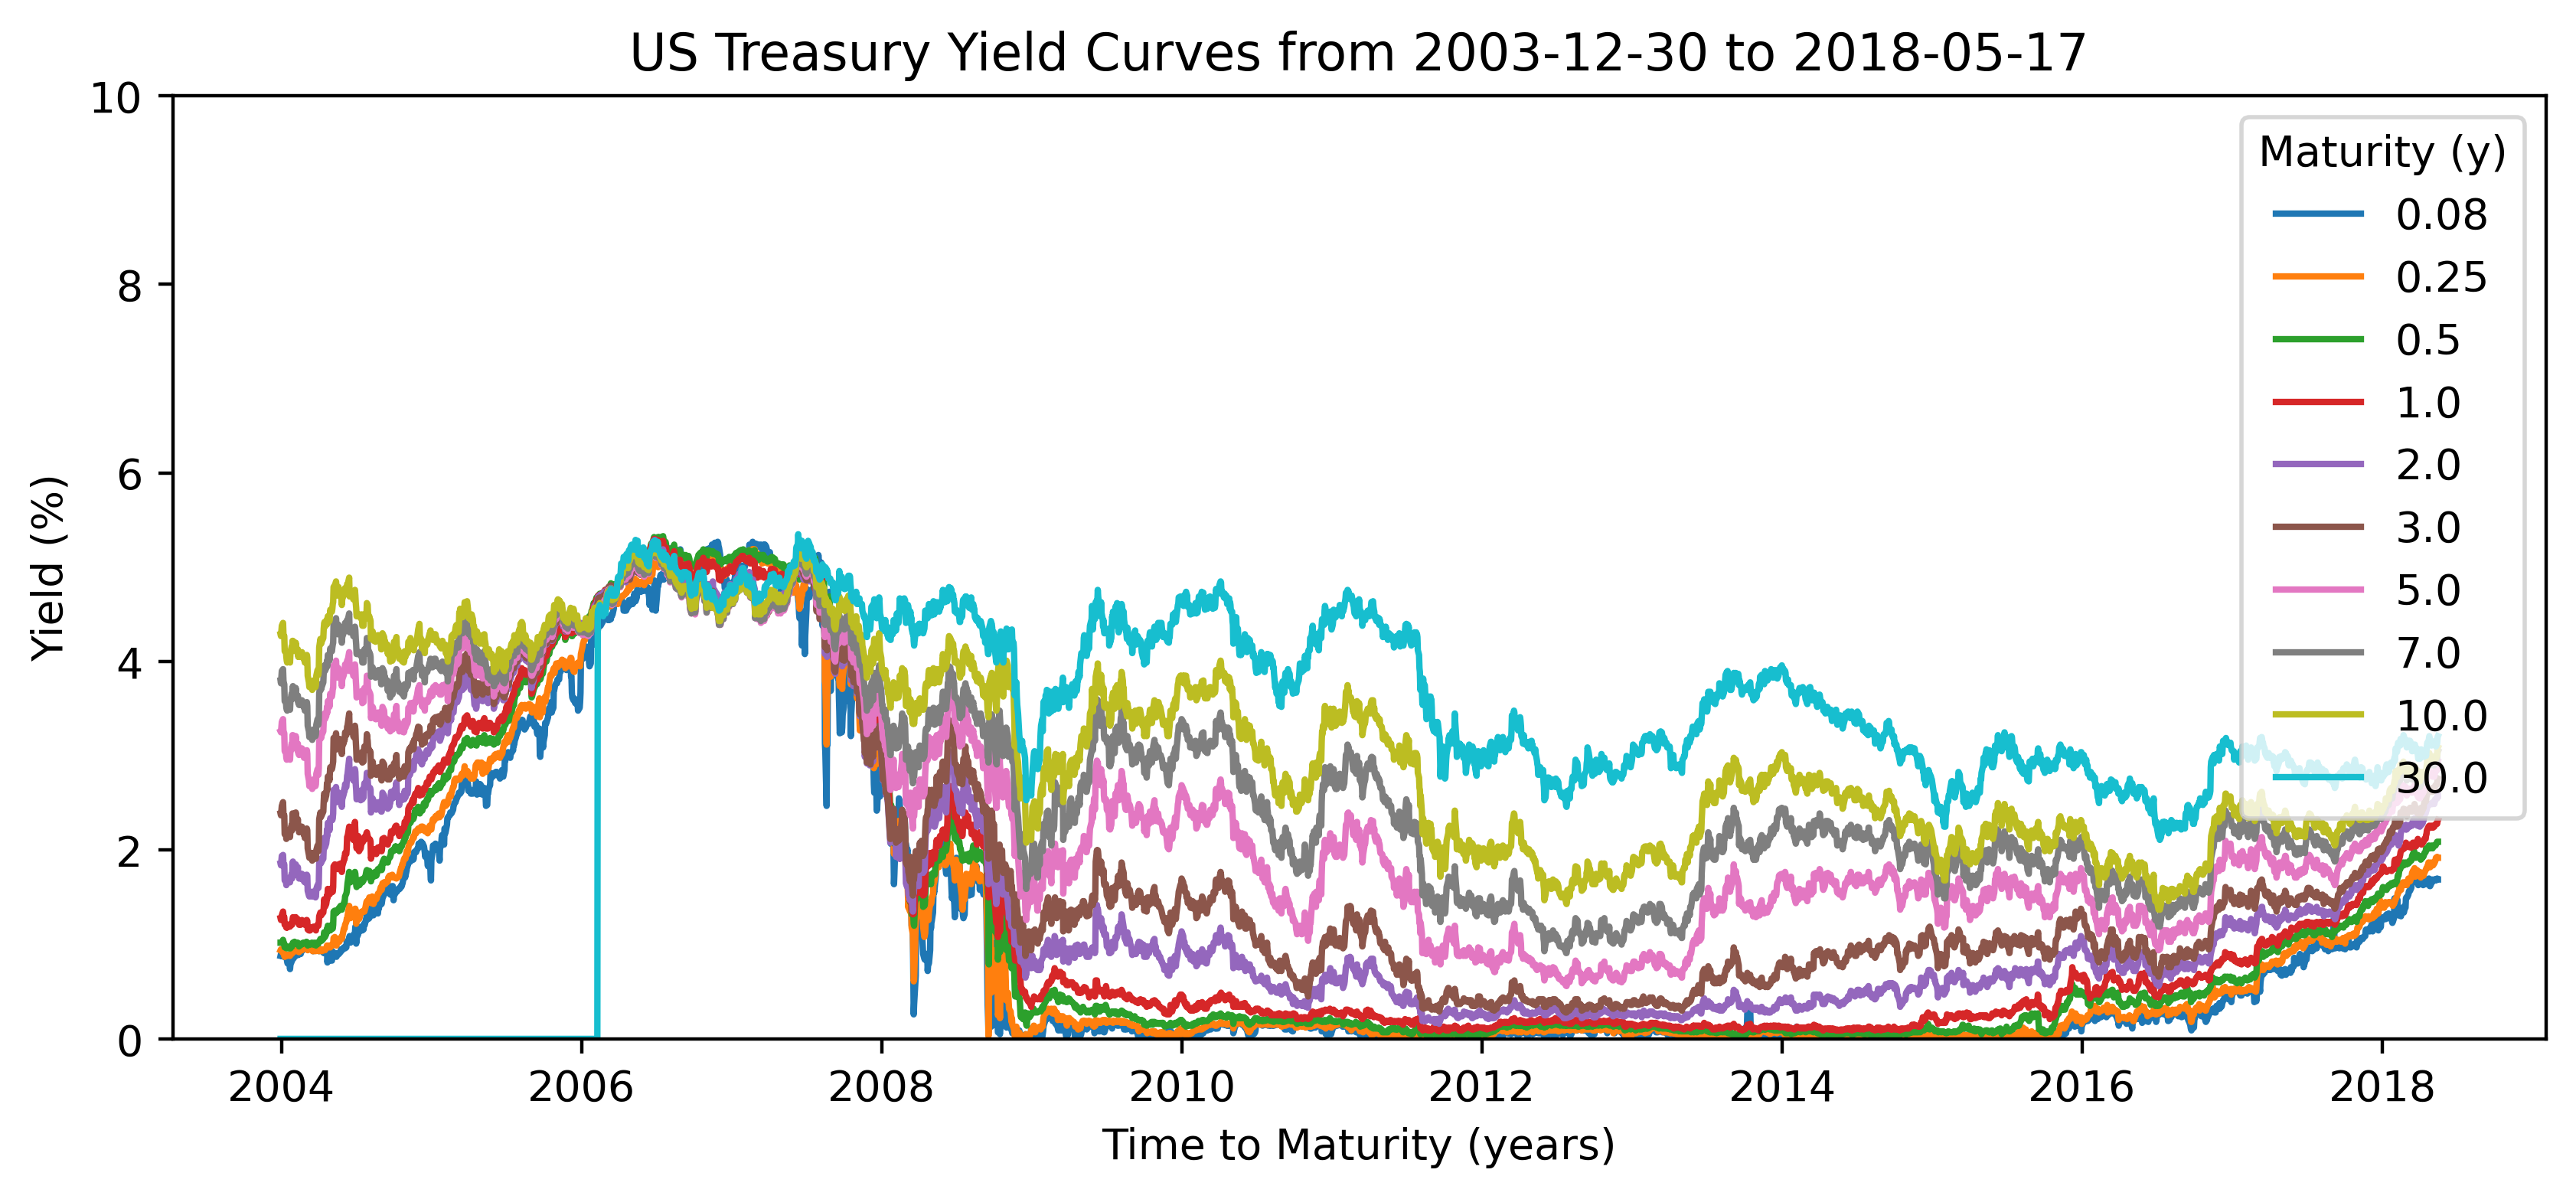

In [42]:
start_idx = 4400 - 900
num_curves = 3600
end_idx = start_idx + num_curves

start_date: Timestamp = yield_curves.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = yield_curves.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(yield_curves.iloc[start_idx:end_idx])
plt.title(f"US Treasury Yield Curves from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.ylim(0, 10)
plt.show()

How do Yield Curves react to market shocks? What is the relationship between Yield Curve volatility and shocks?

Next information:
- Plot rolling vol, and rolling vol correlation
- MR property relative to RF rate according to literature models

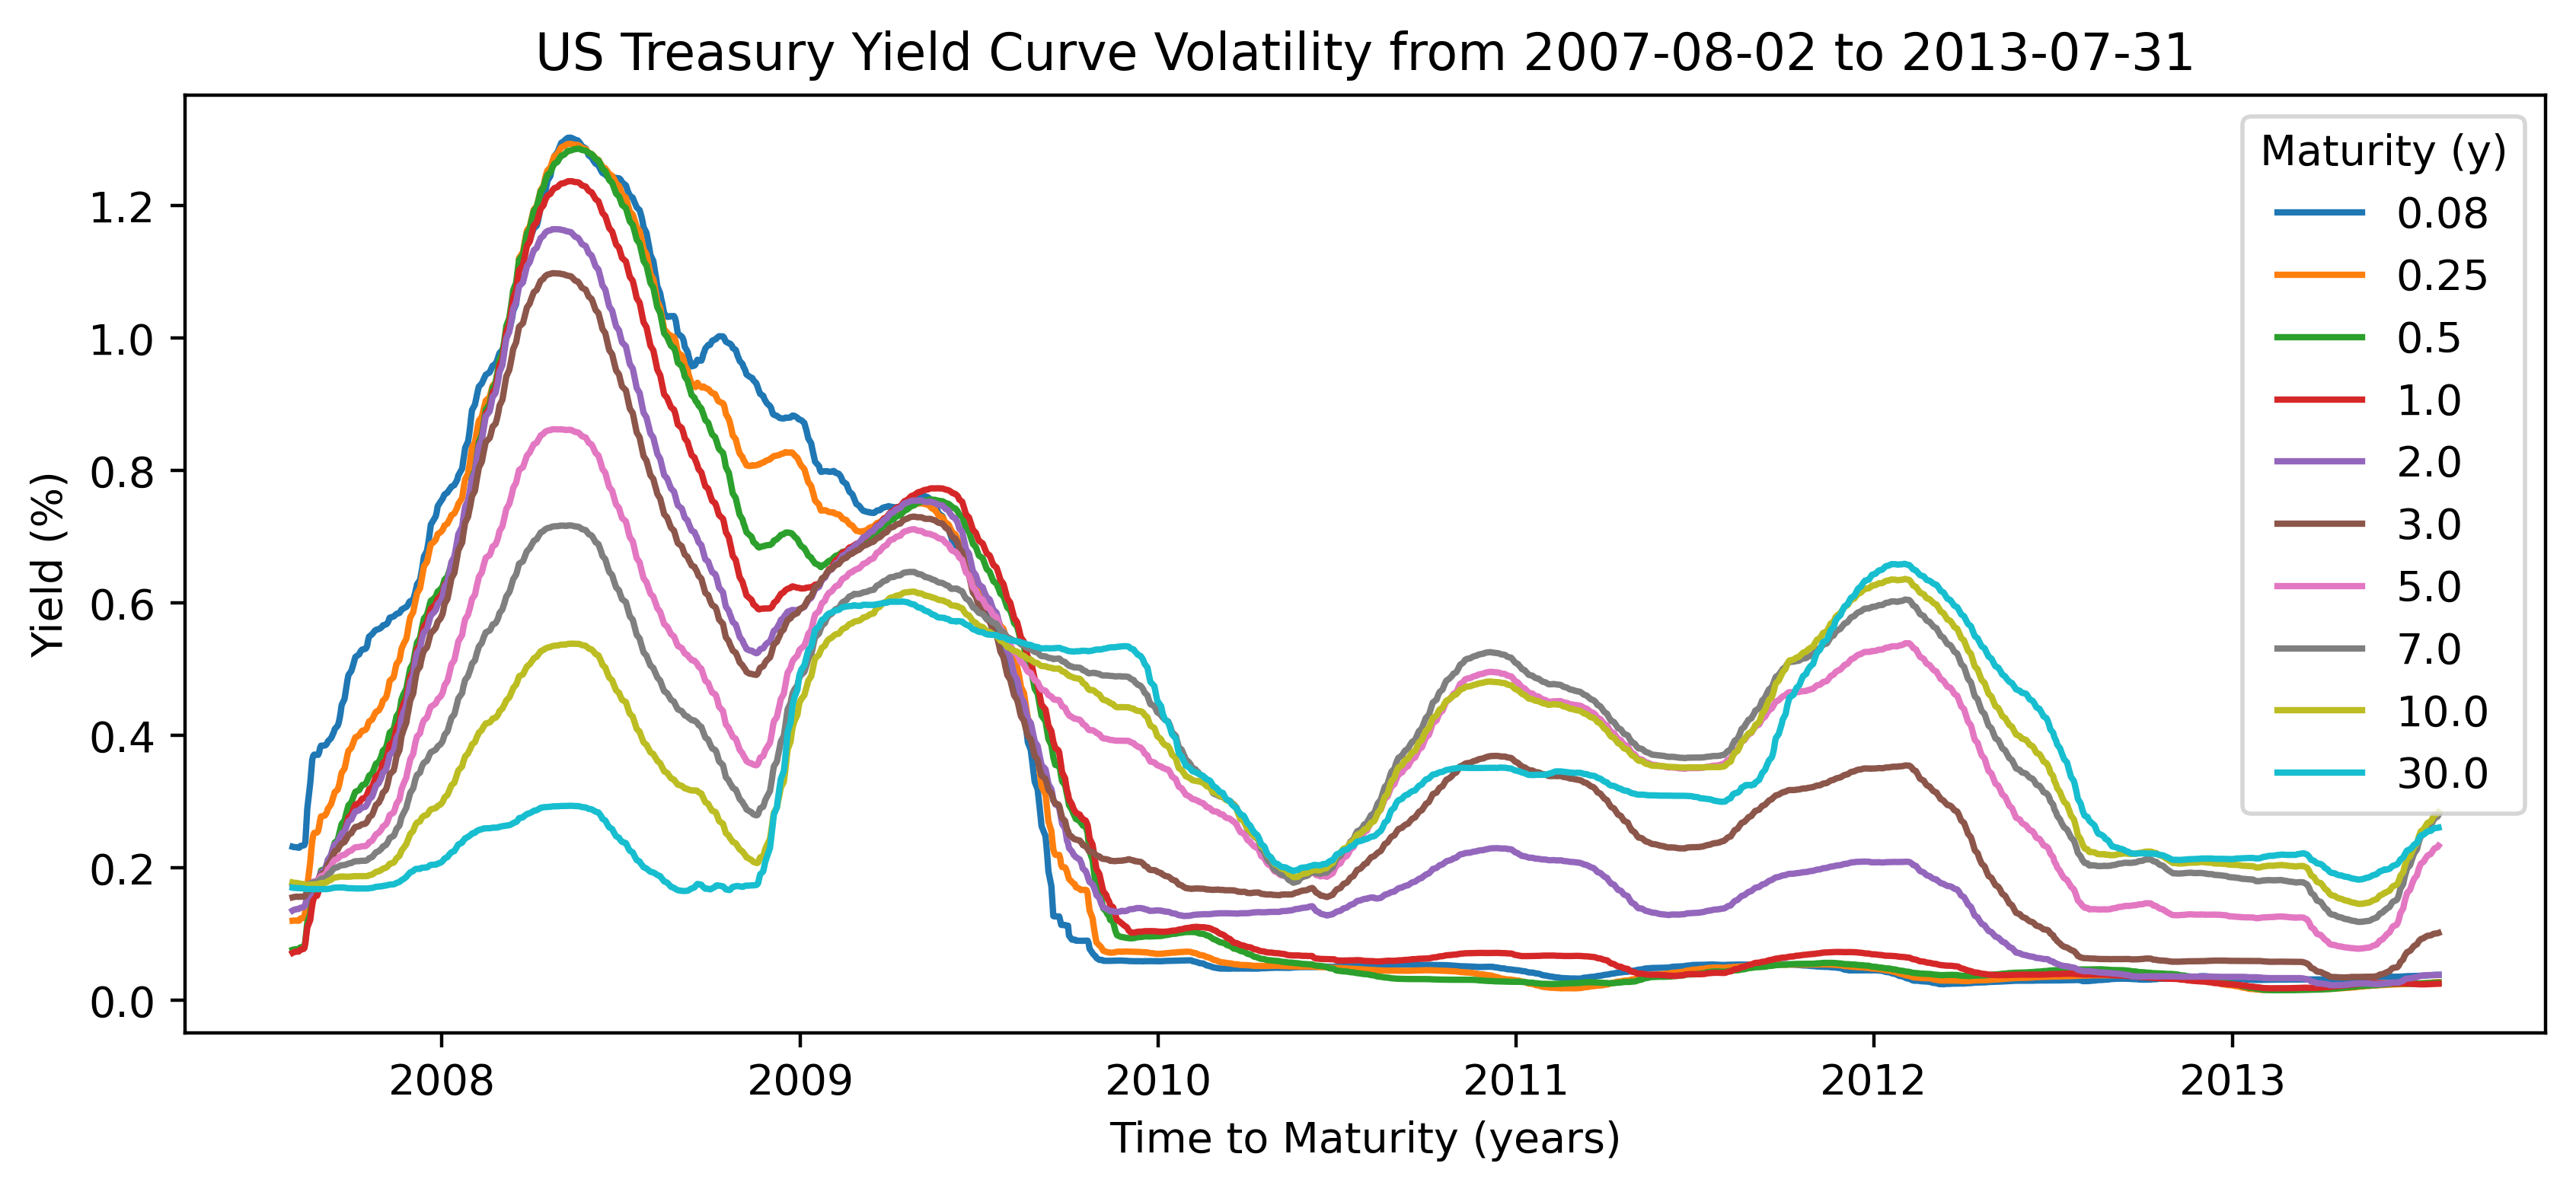

In [43]:
start_idx = 4400 
num_curves = 1500
end_idx = start_idx + num_curves
rolling_vol = yield_curves.rolling(252).std()

start_date: Timestamp = rolling_vol.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = rolling_vol.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(rolling_vol.iloc[start_idx:end_idx])
plt.title(f"US Treasury Yield Curve Volatility from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.show()

### TODO

Add a volatility heatmap, then do a `abs(vol_heatmap - yields_heatmap)` volatility plot which shows where they differ.

## What is the structure of yields and volatility?

We can use Machine Learning in order to understand the structure of yield curves and volatility. We can compare whether or not they are similar


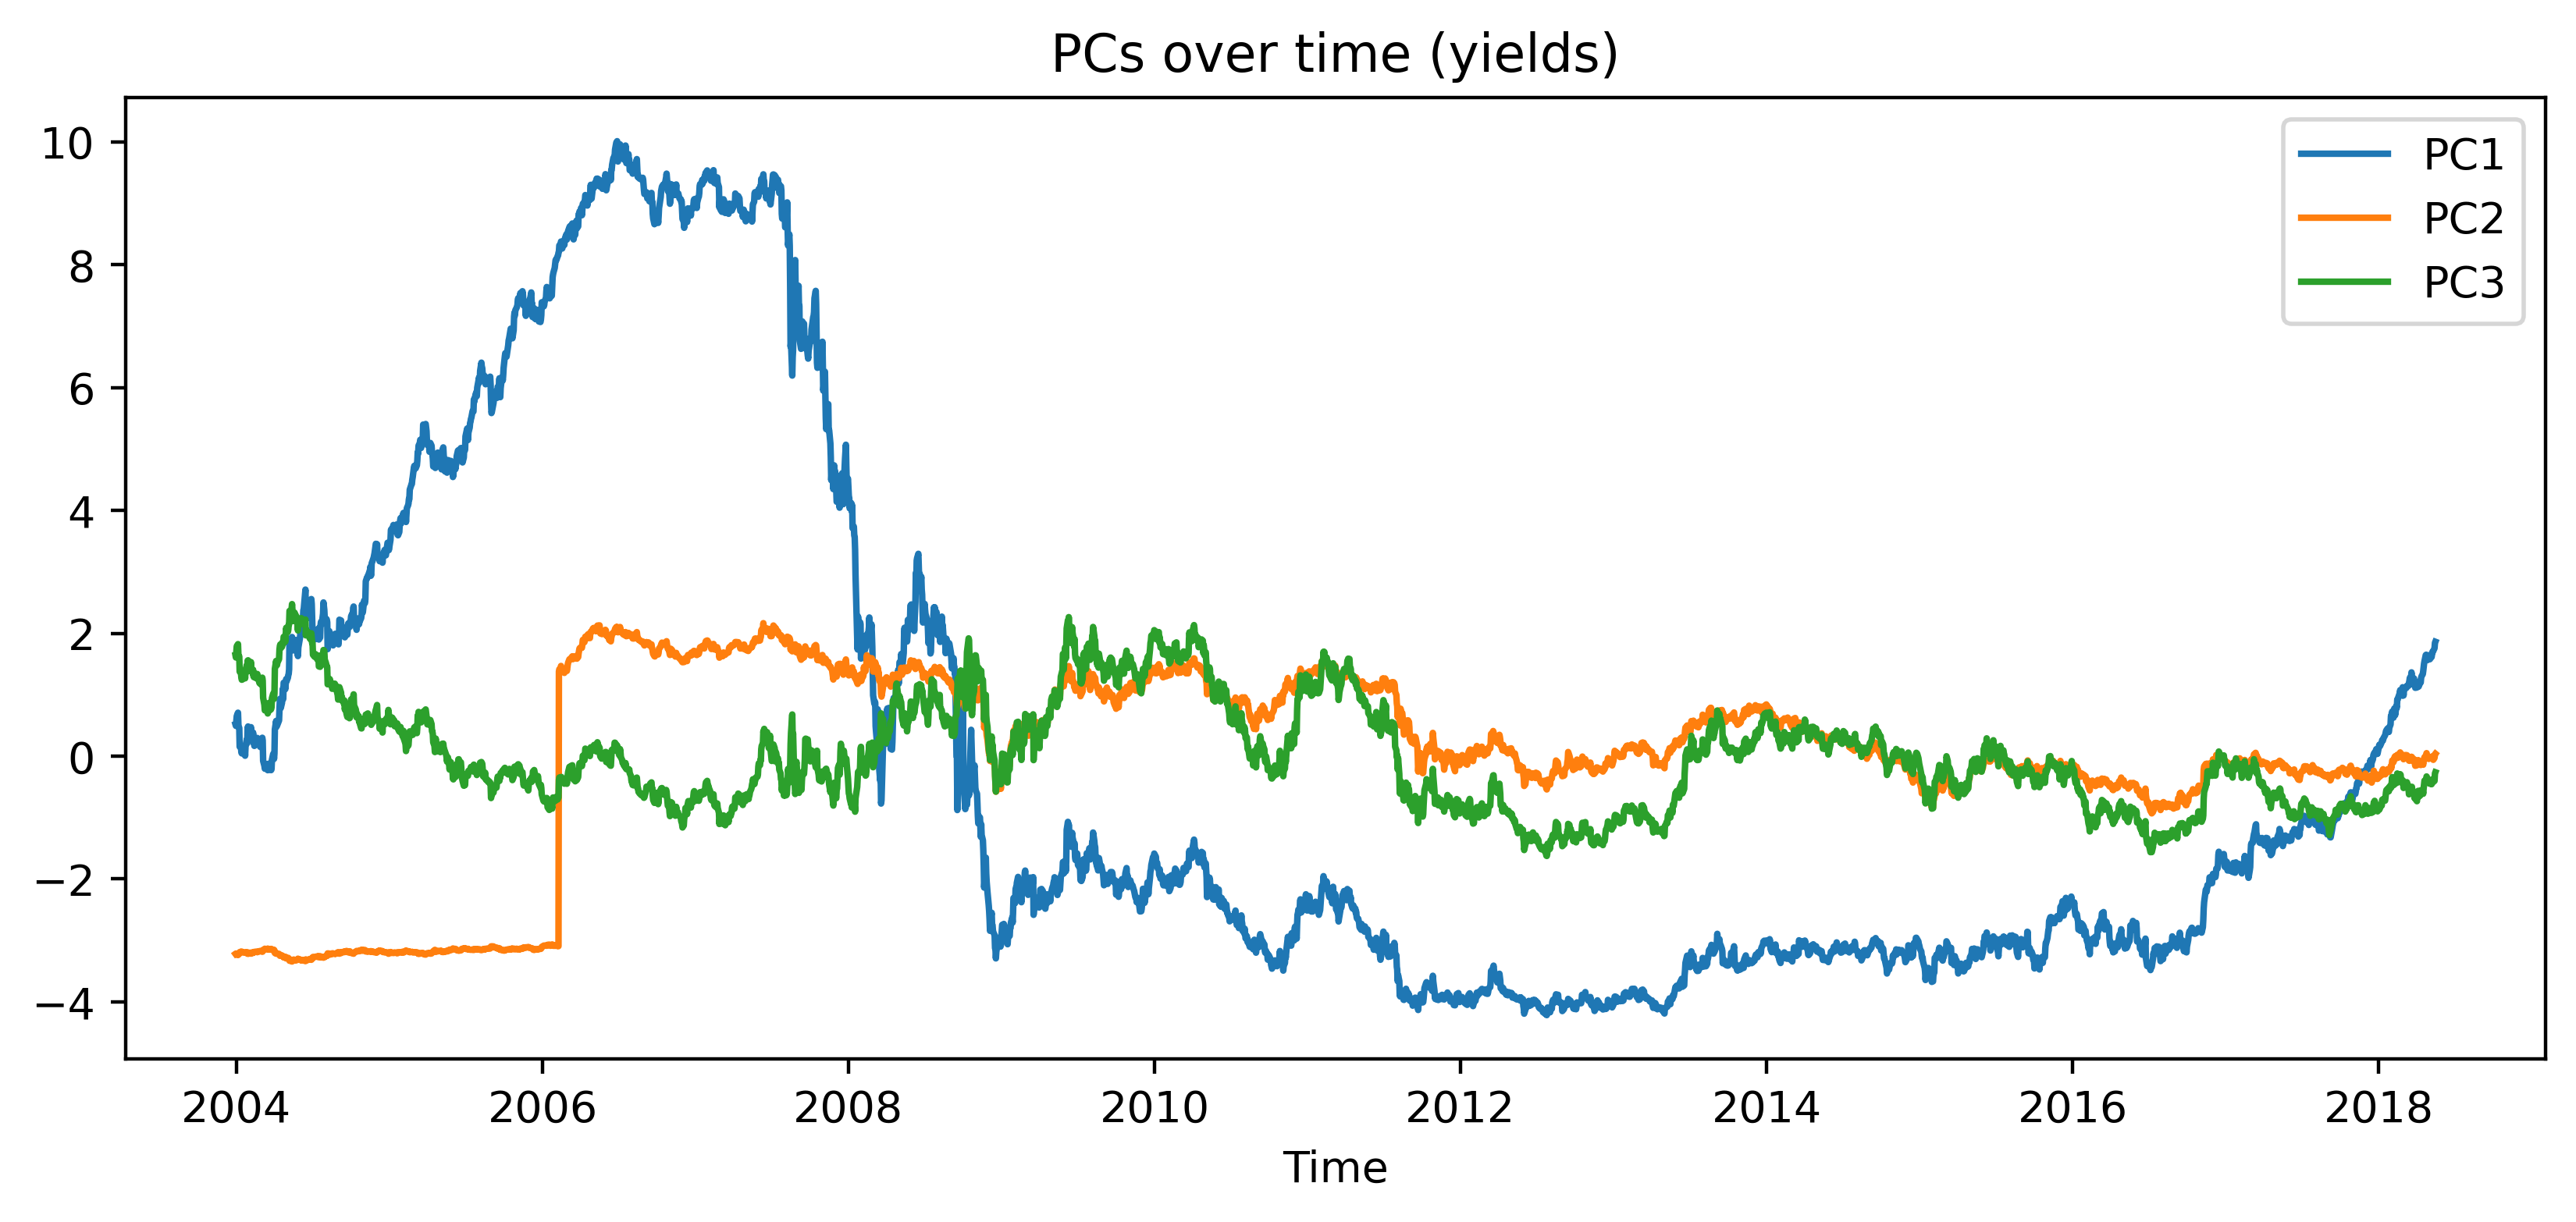

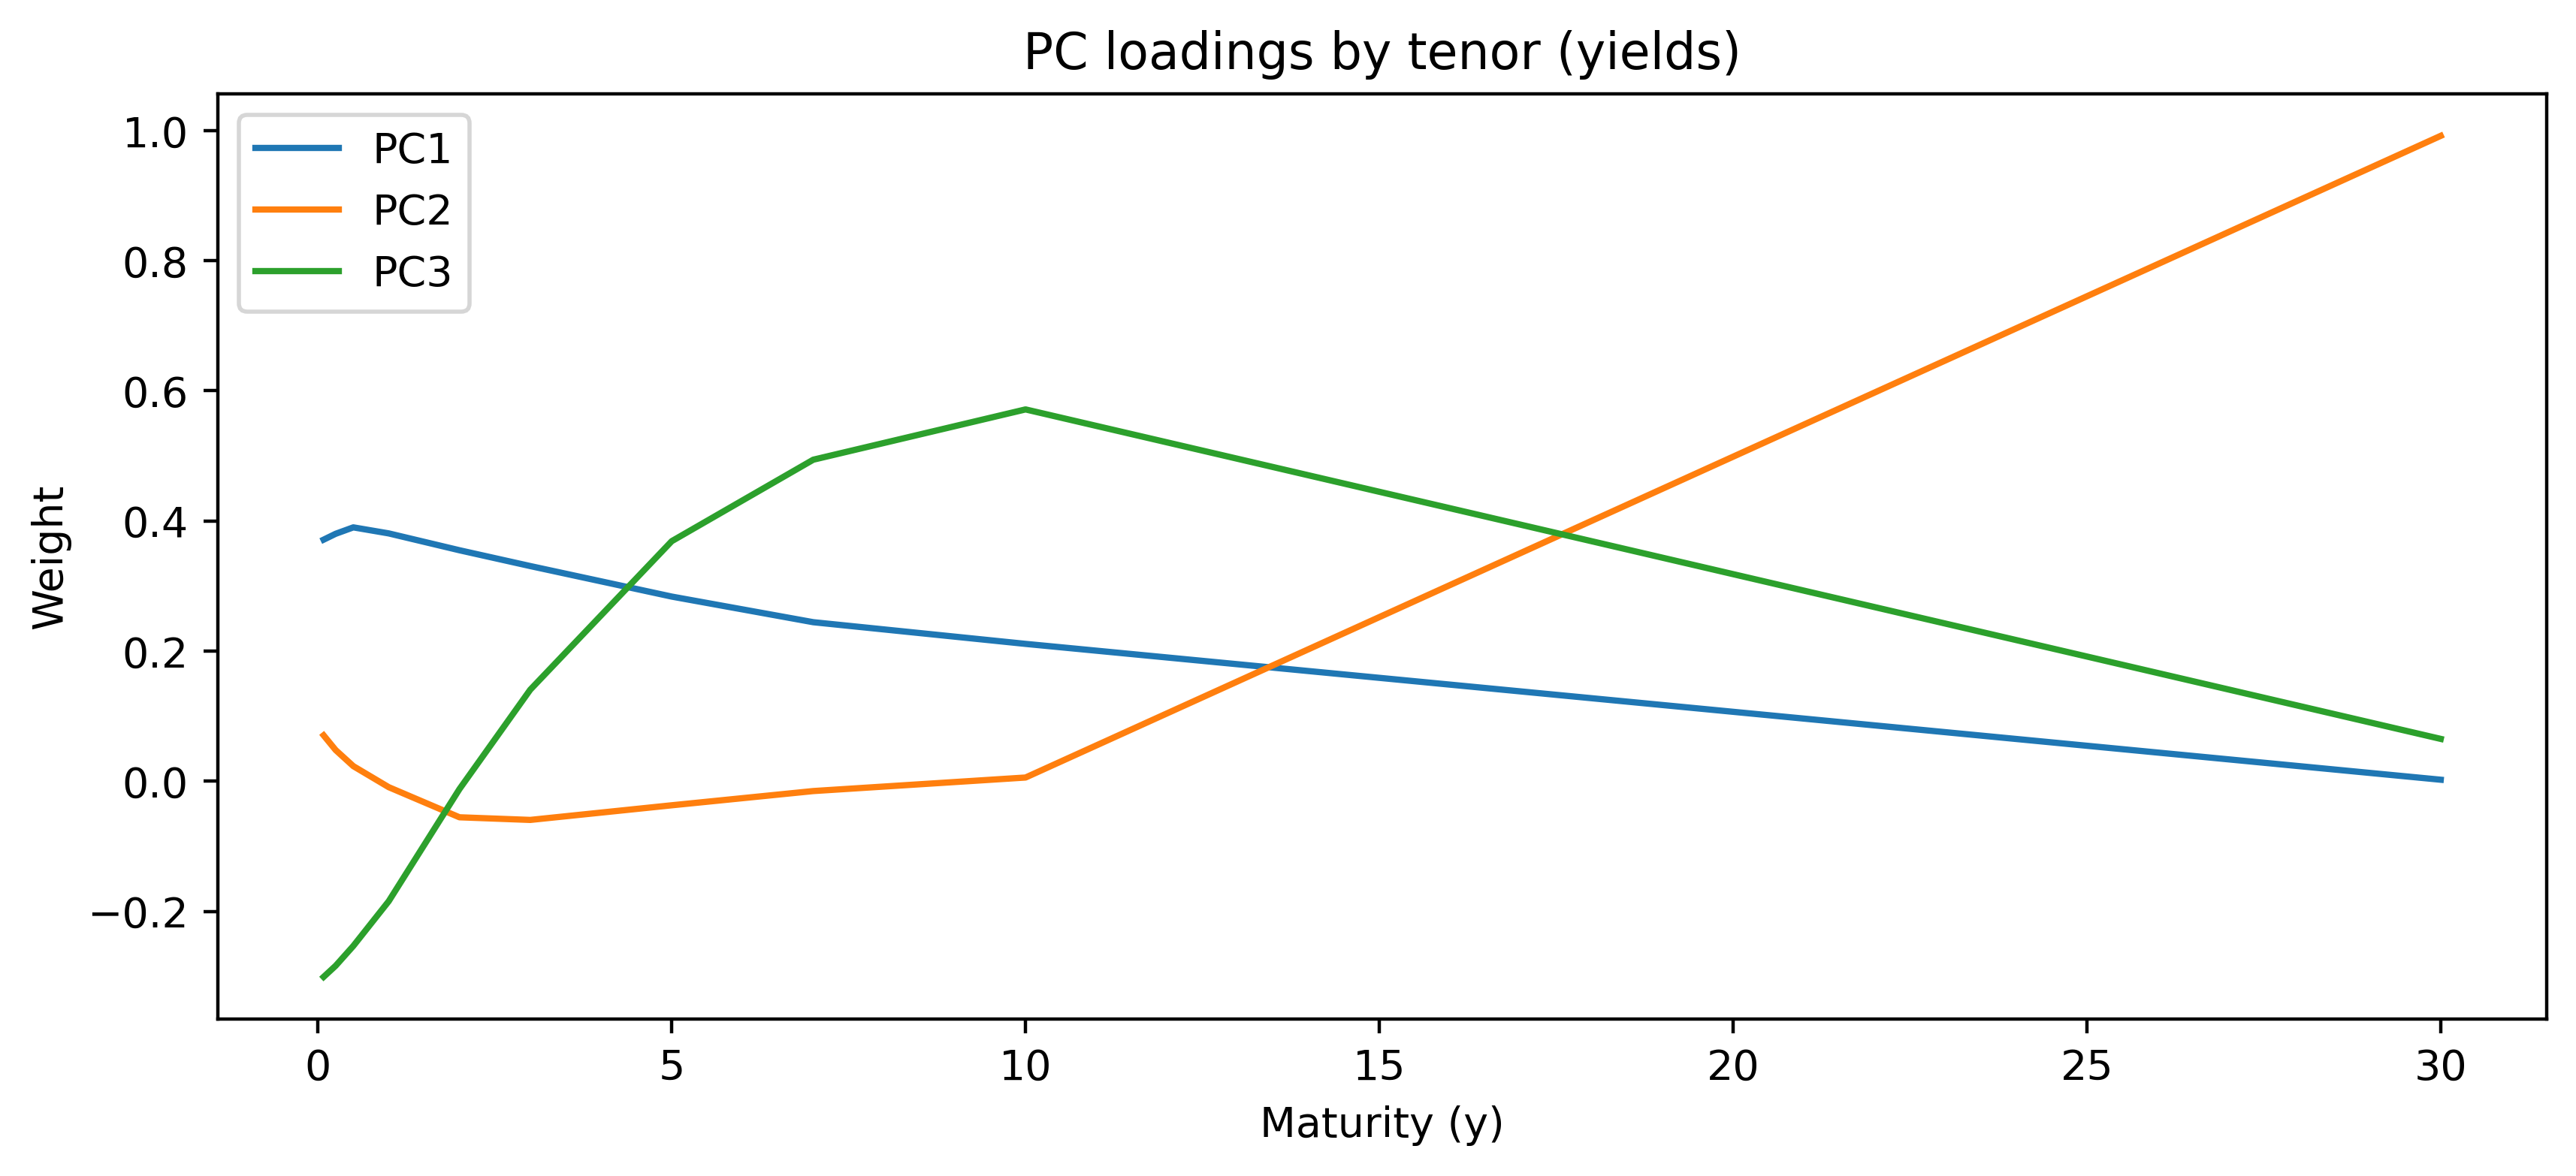

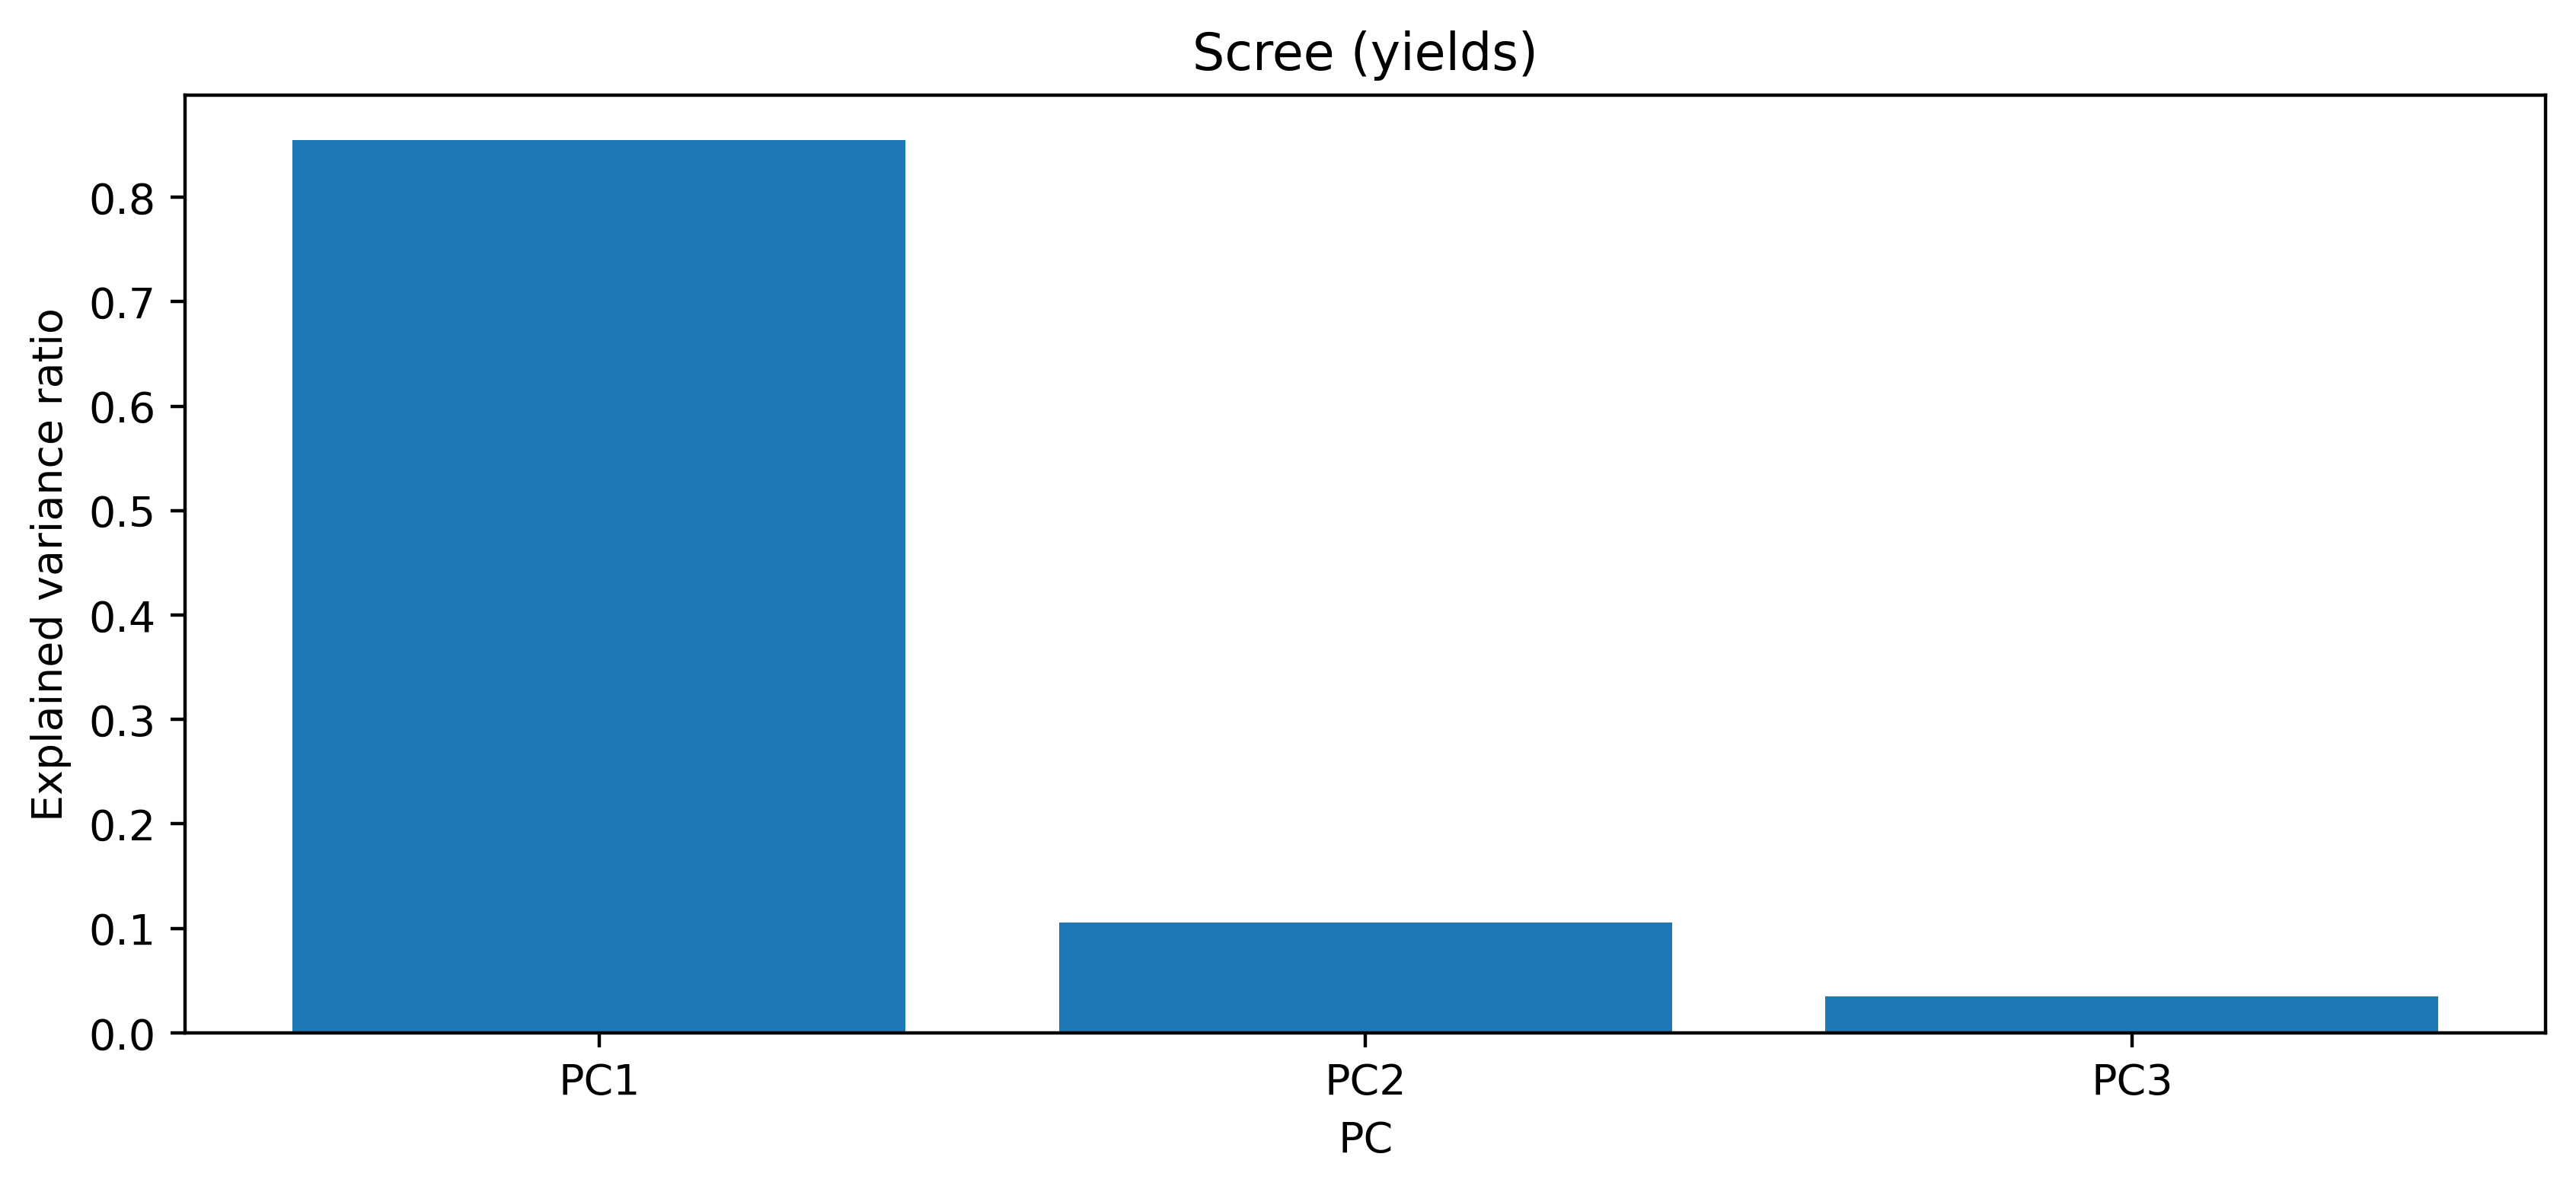

In [35]:
from sklearn.decomposition import PCA

start_idx = 4400 - 900
num_curves = 3600
end_idx = start_idx + num_curves
X = yield_curves.iloc[start_idx:end_idx]
pca = PCA(n_components=3).fit(X)
scores = pca.transform(X)

plt.figure()
plt.plot(X.index, scores)
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time")
plt.title("PCs over time (yields)")
plt.show()

plt.figure()
for i in range(3):
    plt.plot(X.columns, pca.components_[i], label=f"PC{i+1}")
plt.xlabel("Maturity (y)")
plt.ylabel("Weight")
plt.legend()
plt.title("PC loadings by tenor (yields)")
plt.show()

plt.figure()
plt.bar([1, 2, 3], pca.explained_variance_ratio_)
plt.xticks([1, 2, 3], ["PC1", "PC2", "PC3"])
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.title("Scree (yields)")
plt.show()

In [36]:
pca.explained_variance_ratio_.cumsum()

array([0.85507584, 0.96082765, 0.99595884])

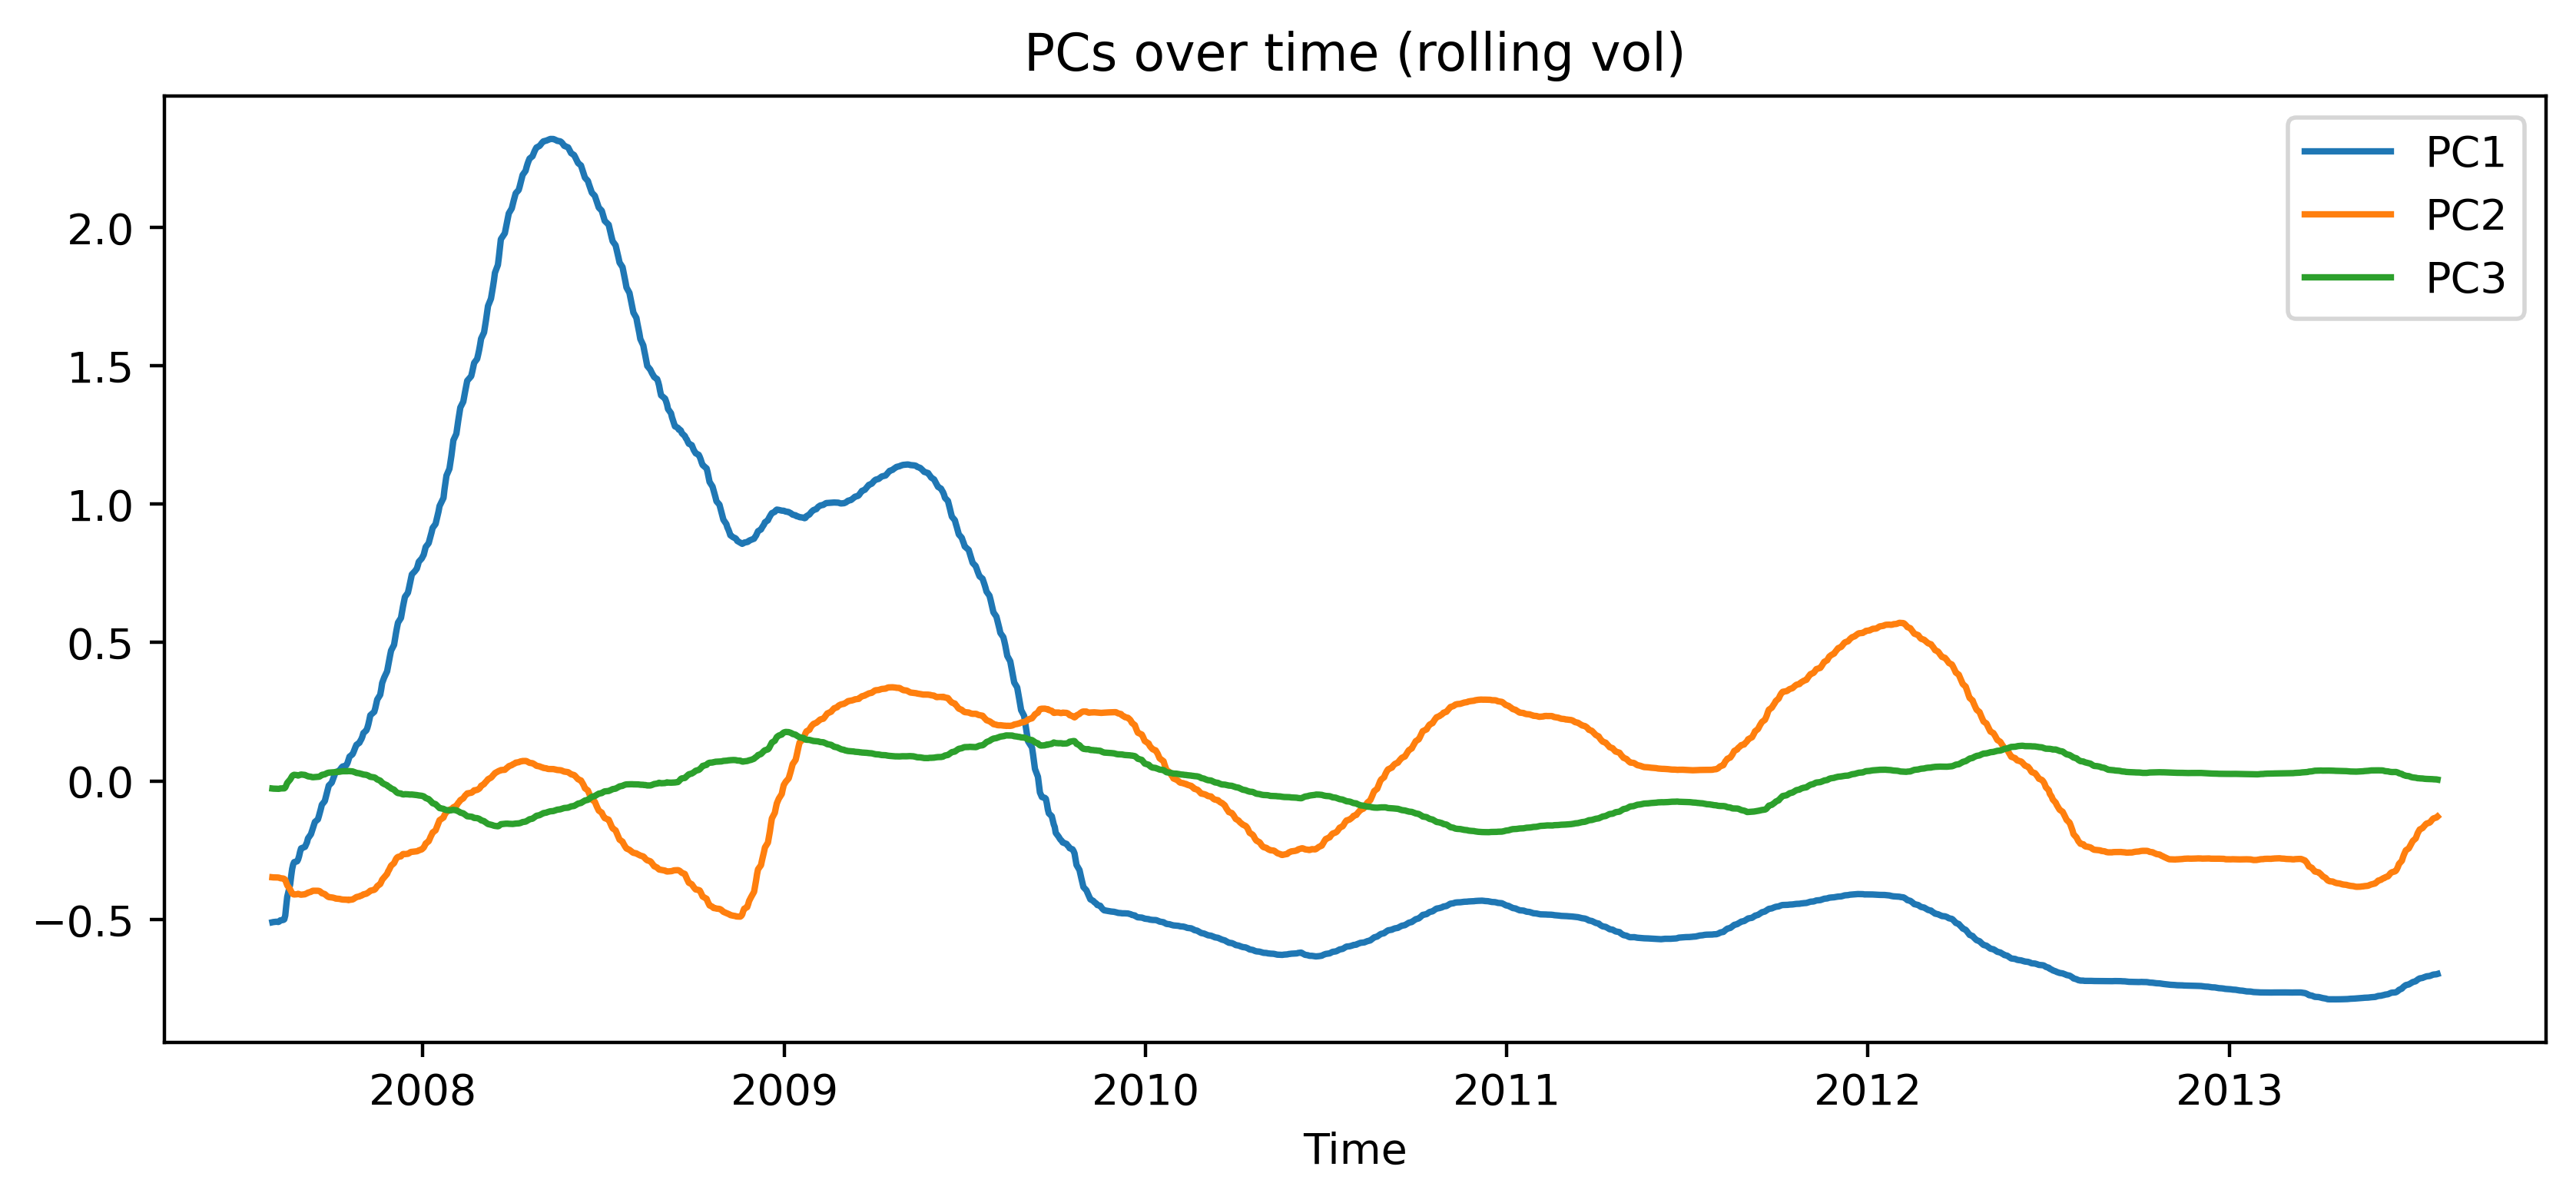

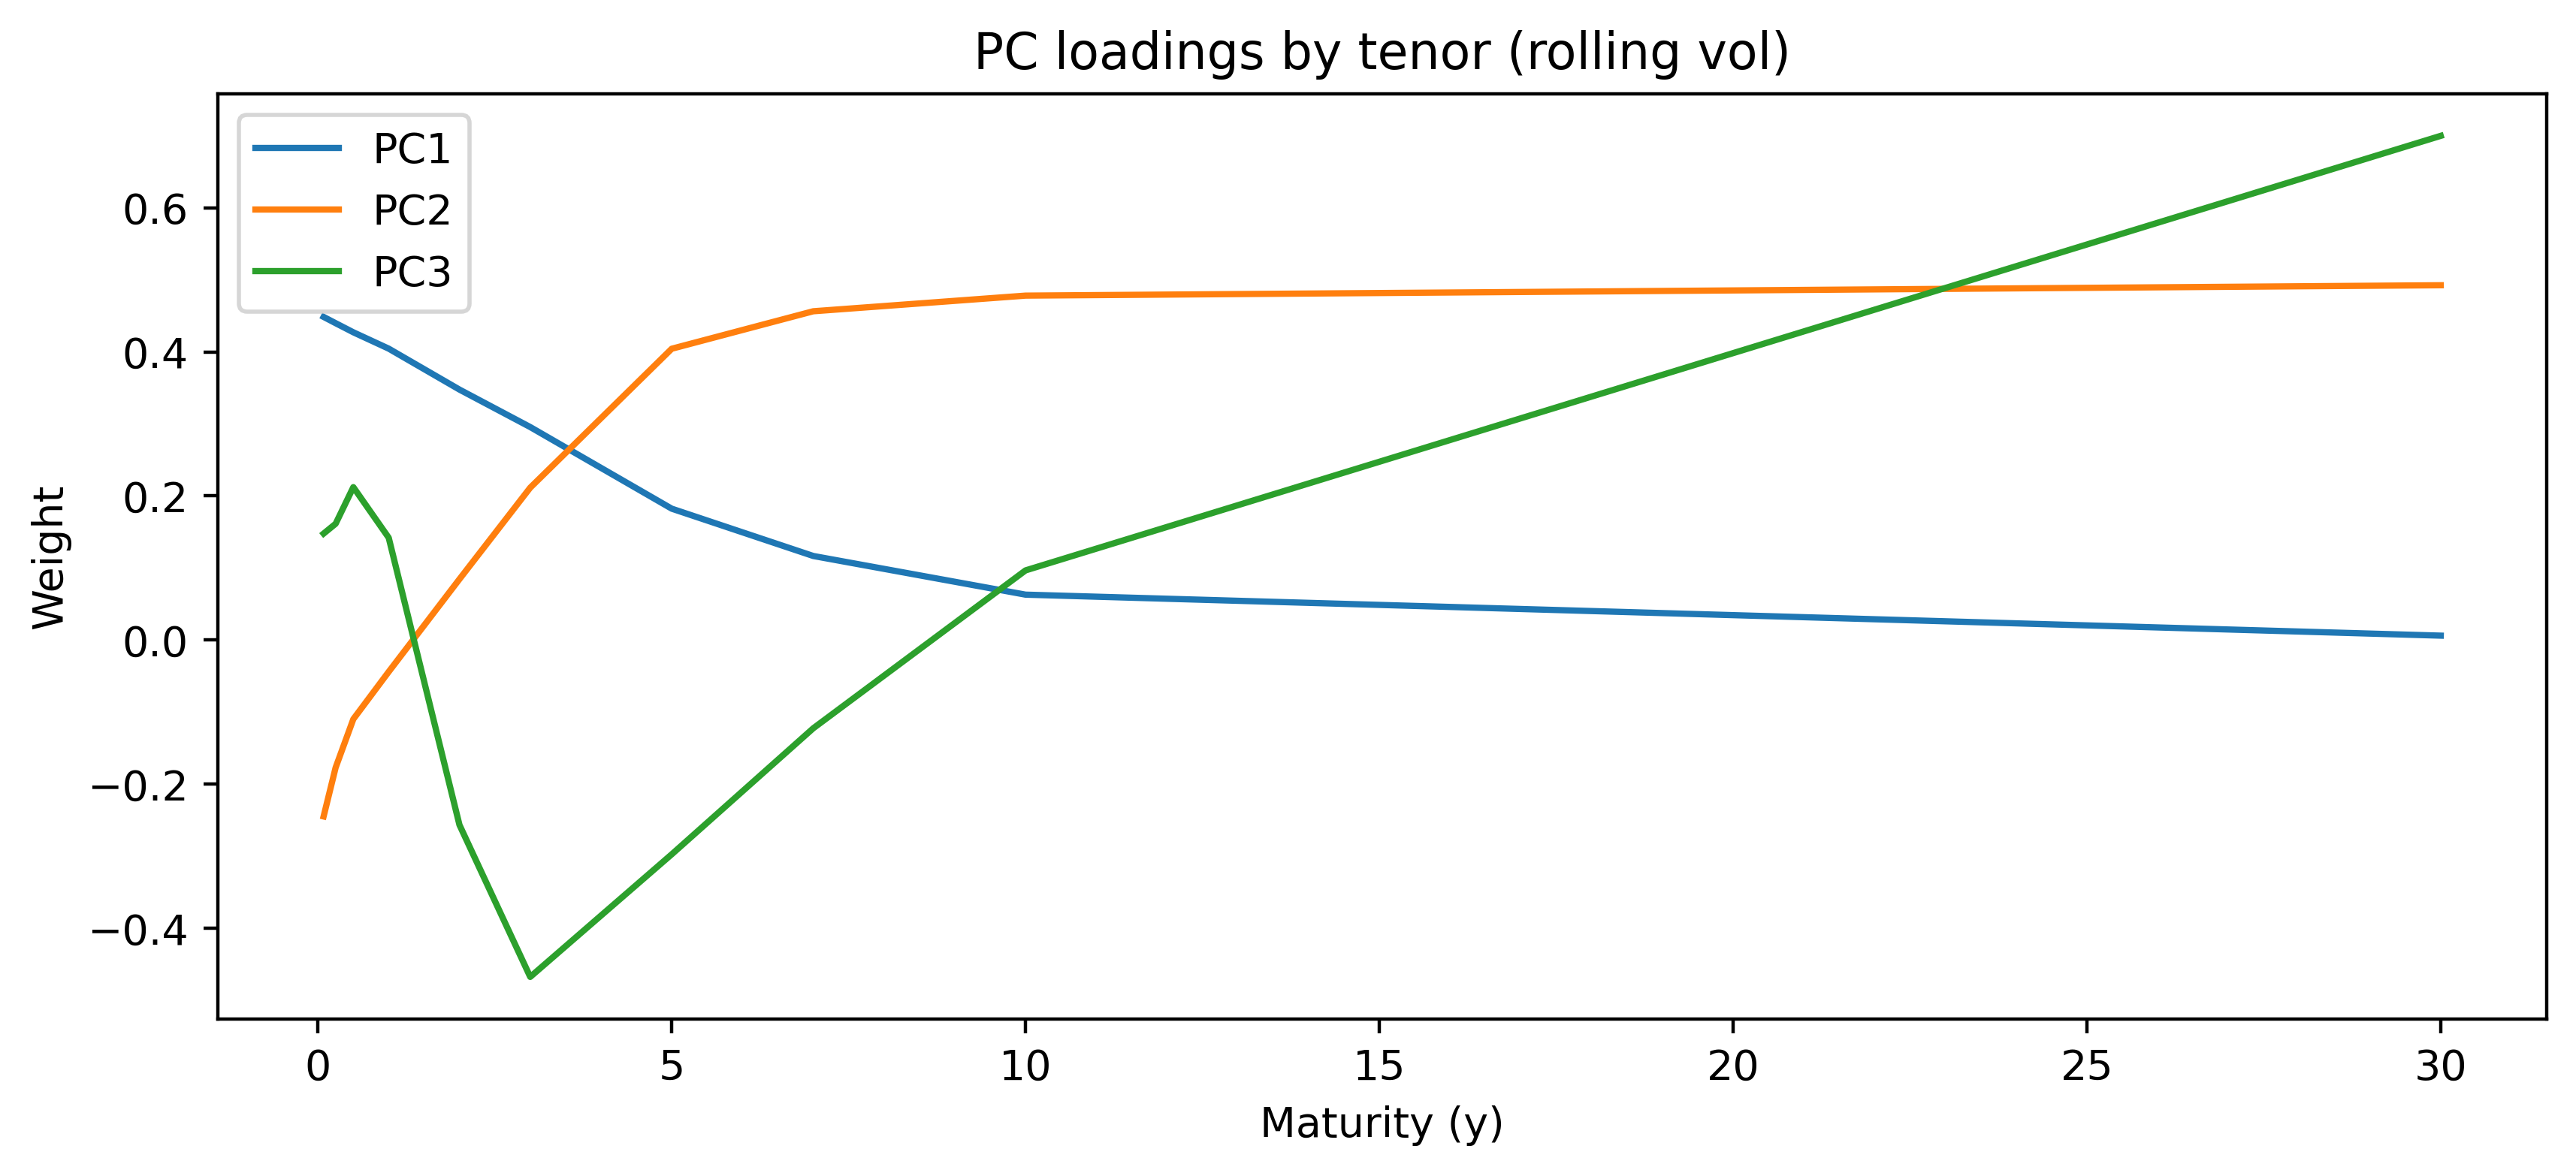

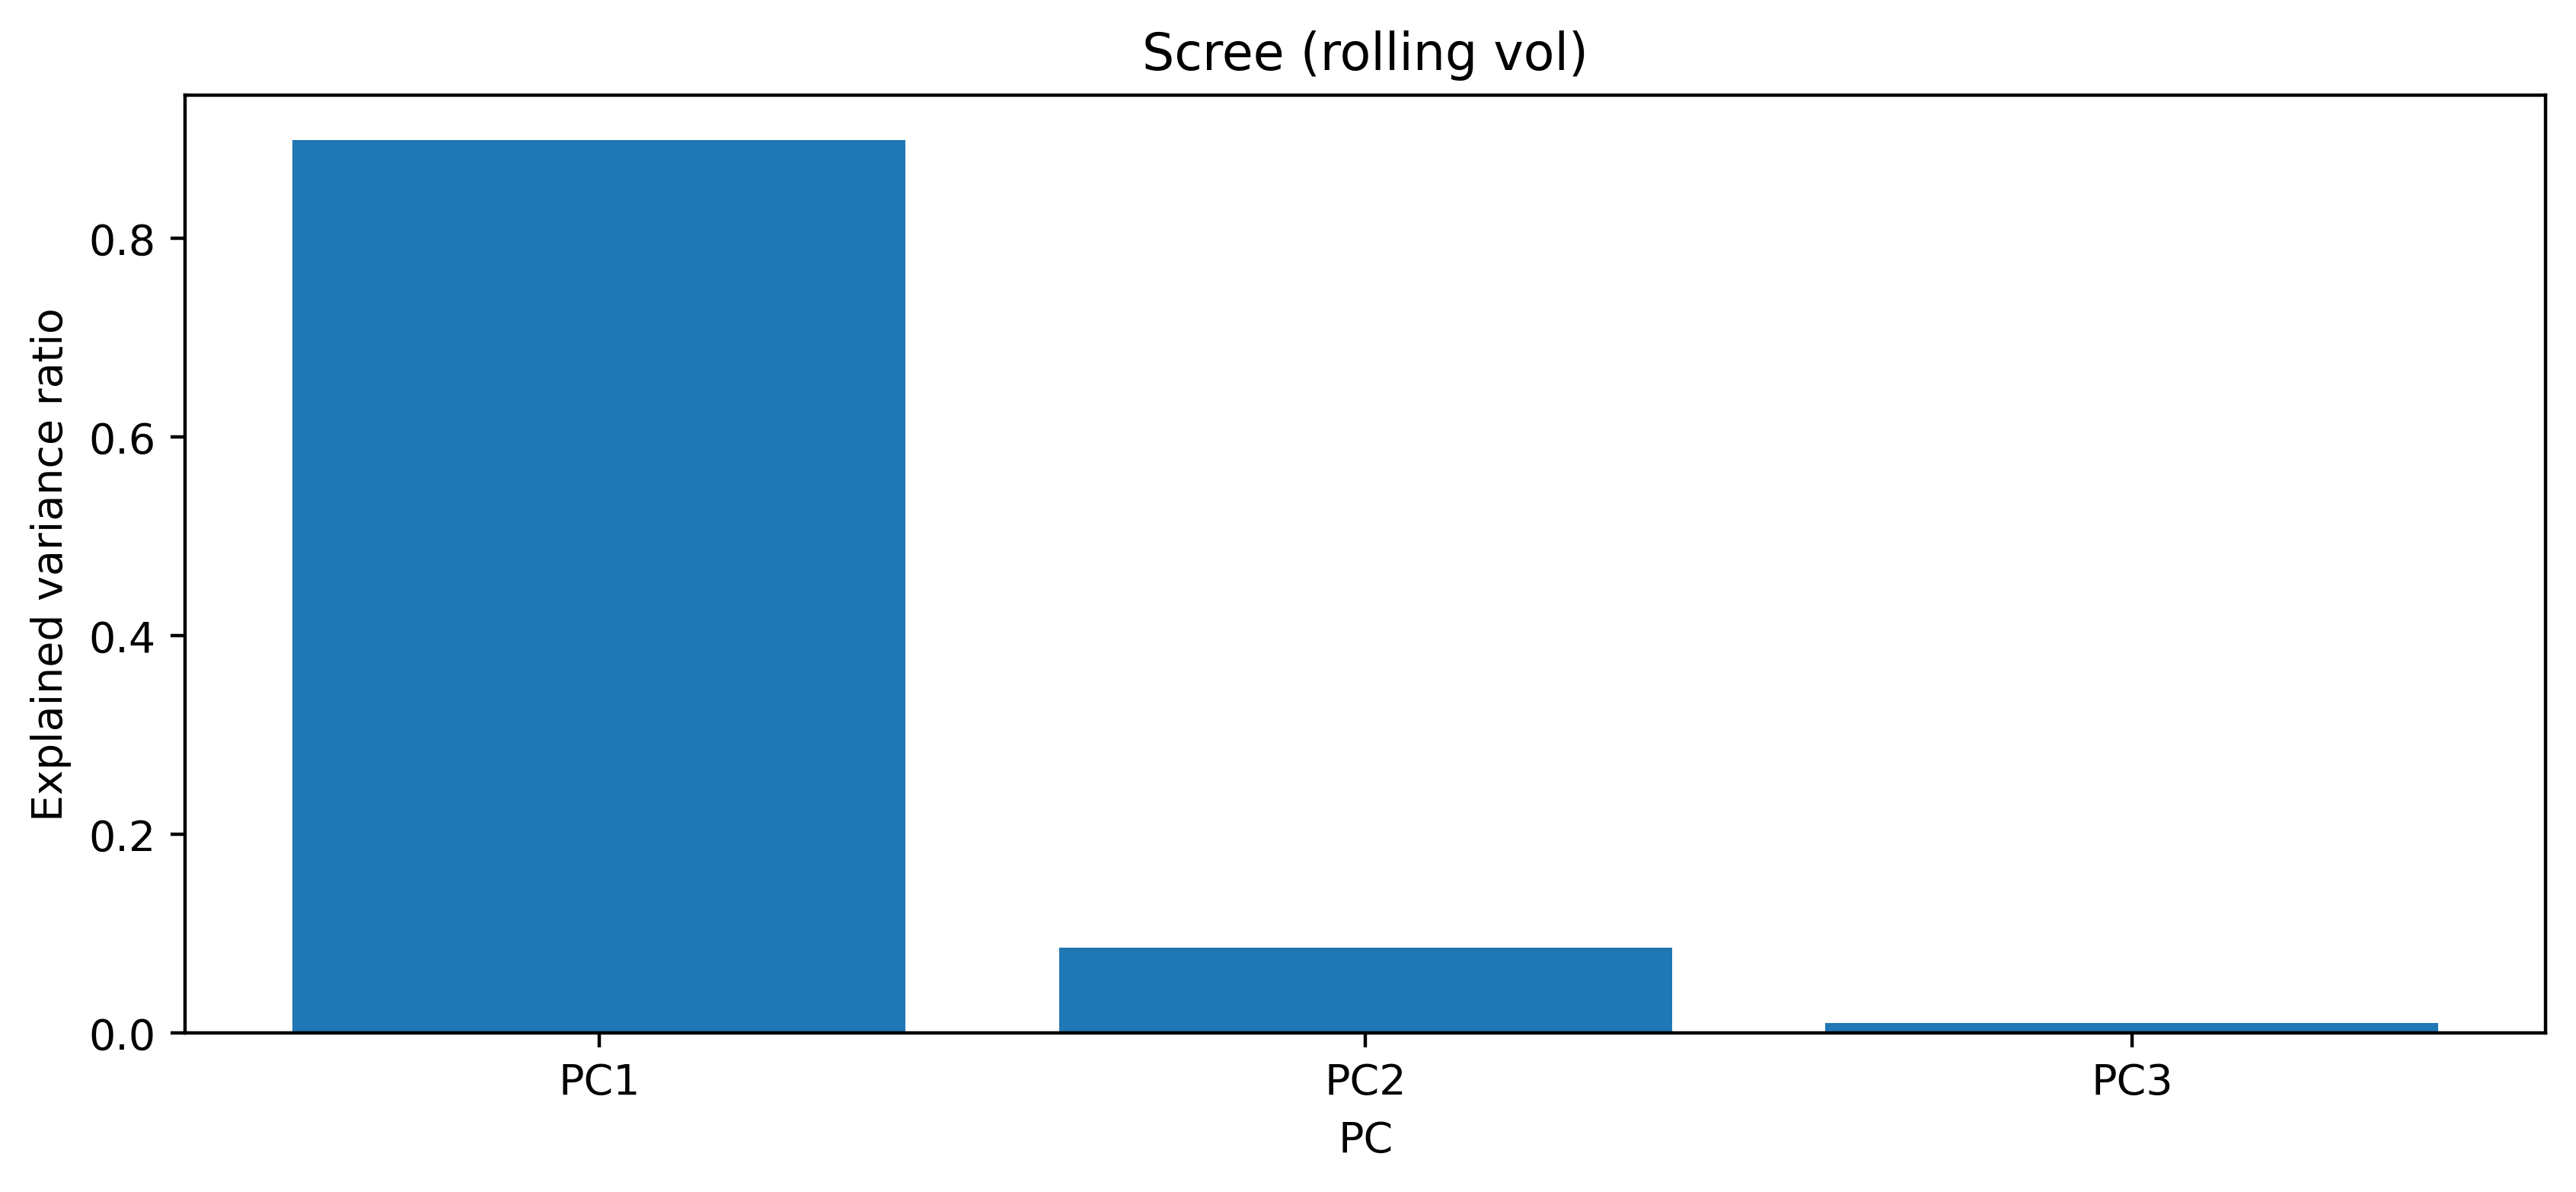

In [37]:
from sklearn.decomposition import PCA

rolling_vol = yield_curves.rolling(252).std()
vol_start_idx = 4400
vol_num_curves = 1500
vol_end_idx = vol_start_idx + vol_num_curves
vol_X = rolling_vol.iloc[vol_start_idx:vol_end_idx].dropna(axis=0)
vol_pca = PCA(n_components=3).fit(vol_X)
vol_scores = vol_pca.transform(vol_X)

plt.figure()
plt.plot(vol_X.index, vol_scores)
plt.legend(["PC1", "PC2", "PC3"])
plt.xlabel("Time")
plt.title("PCs over time (rolling vol)")
plt.show()

plt.figure()
for i in range(3):
    plt.plot(vol_X.columns, vol_pca.components_[i], label=f"PC{i+1}")
plt.xlabel("Maturity (y)")
plt.ylabel("Weight")
plt.legend()
plt.title("PC loadings by tenor (rolling vol)")
plt.show()

plt.figure()
plt.bar([1, 2, 3], vol_pca.explained_variance_ratio_)
plt.xticks([1, 2, 3], ["PC1", "PC2", "PC3"])
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.title("Scree (rolling vol)")
plt.show()

Look at PC2, clearly seems to follow some sort of pattern. Can we do a FFT to understand whether there is a yearly component to it?

Can we quantify the difference/similarity between them? What measures could we use to measure the similarity in structure?

In [53]:
from numpy.linalg import norm

pc_num = 1
x = pca.components_[pc_num-1]
y = vol_pca.components_[pc_num-1]
pc_similarity = np.dot(x,y) / (norm(x)*norm(y))
print(f"Sim score squared gives: {(pc_similarity) ** 2: .2f} for PC{pc_num}")

Sim score squared gives:  0.94 for PC1


## Regime detection using Unsupervised Machine Learning

We have a dataset of yield curves and we wish to categorise each set into belonging to a specific regime:

$$
\forall i \in \{0,1,..,n \}. \quad \exists r \in \{0,1,..,k\}. \quad x_i \in R_r
$$
Where any time point belongs exactly to a regime. 

Can anyone discuss different regimes in time? Use your financial literacy, what do you know about historical market regimes.

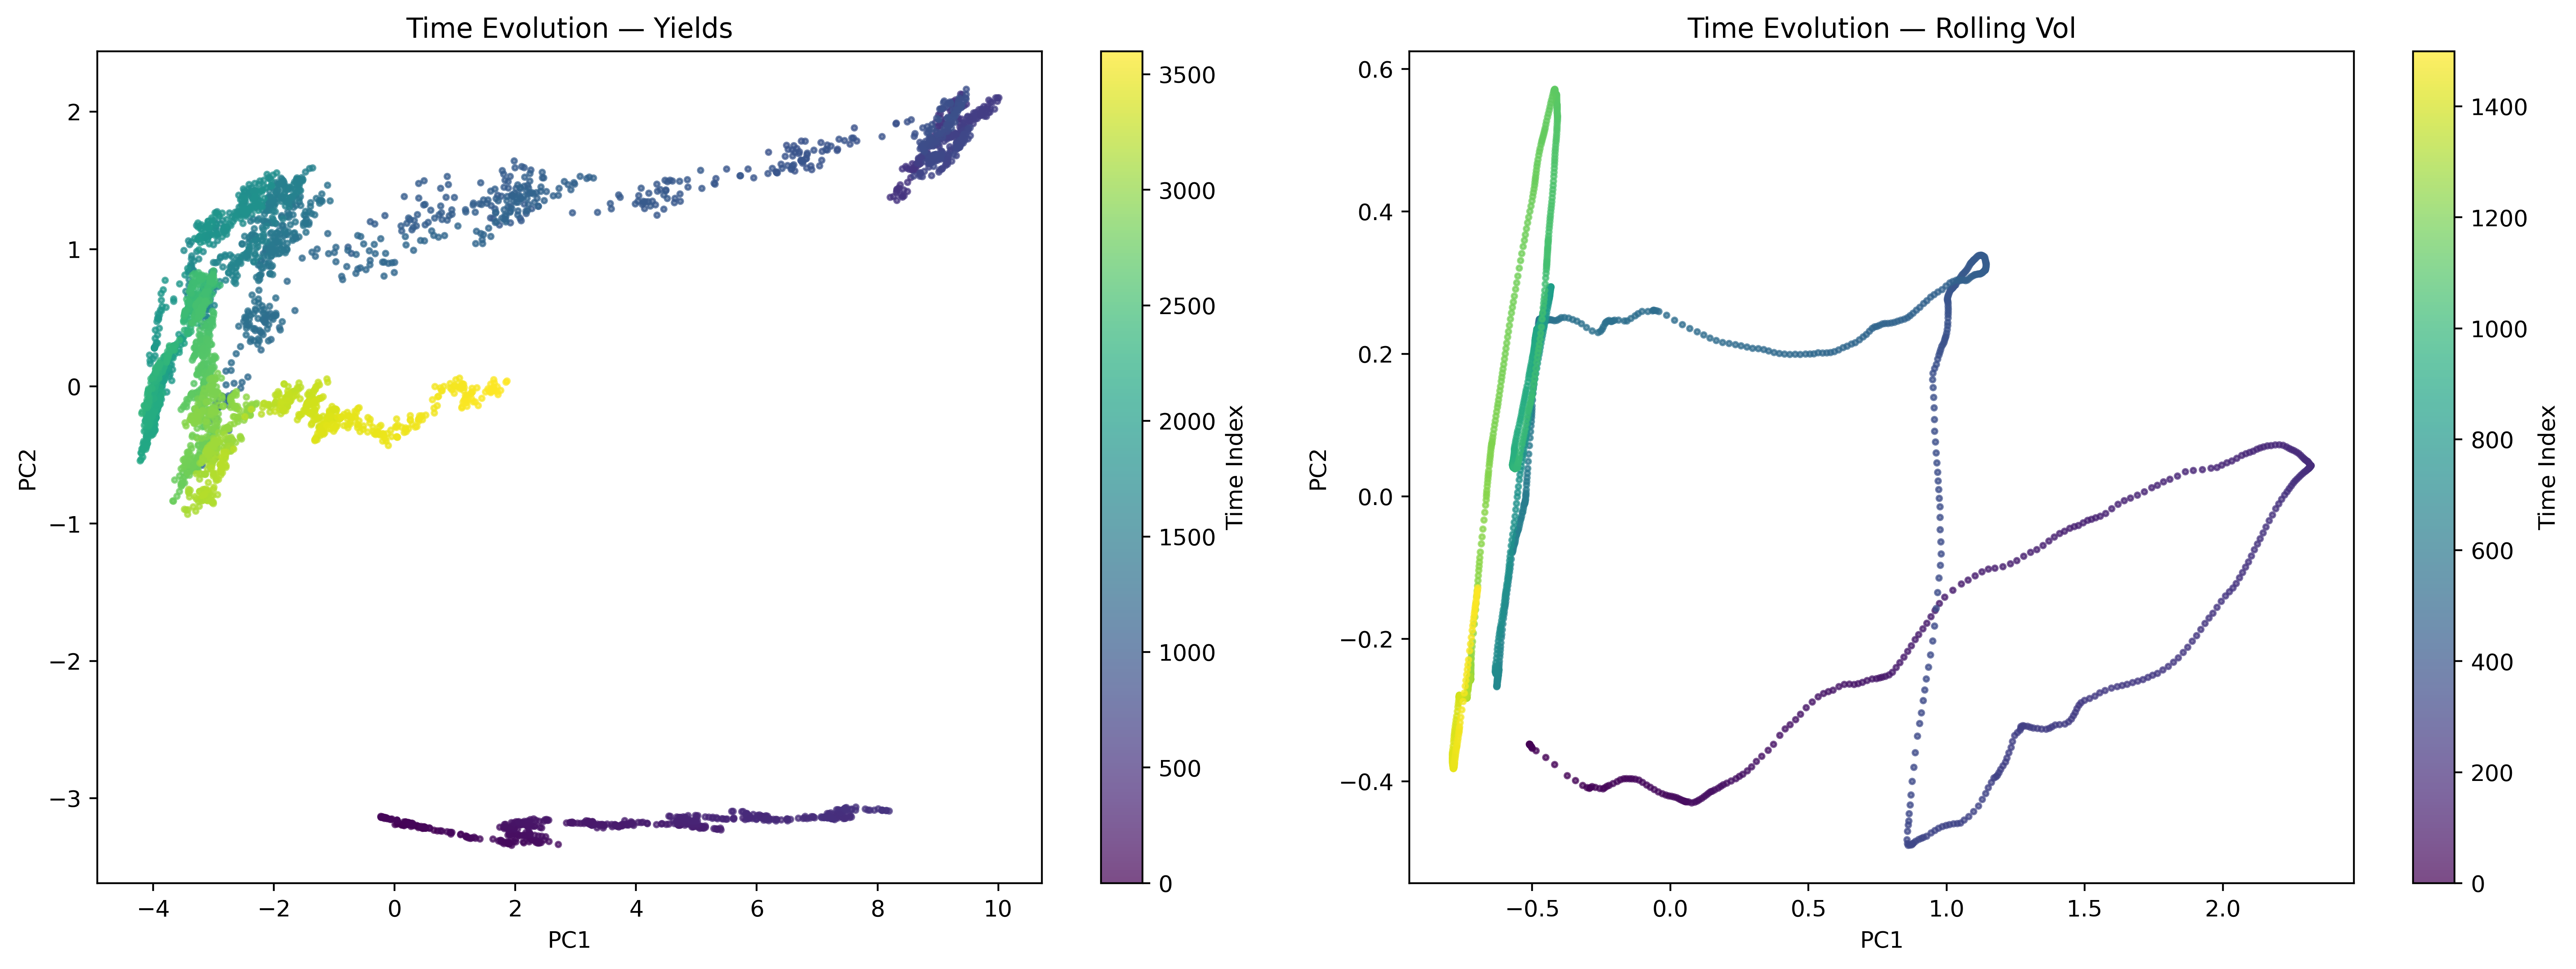

In [92]:
from sklearn.decomposition import PCA

yields_start, yields_n = 4400 - 900, 3600
yields_end = yields_start + yields_n
yields_X = yield_curves.iloc[yields_start:yields_end]
yields_pca = PCA(n_components=2).fit(yields_X)
yields_scores = yields_pca.transform(yields_X)

rolling_vol = yield_curves.rolling(252).std()
vol_start, vol_n = 4400, 1500
vol_end = vol_start + vol_n
vol_X = rolling_vol.iloc[vol_start:vol_end].dropna(axis=0)
vol_pca = PCA(n_components=2).fit(vol_X)
vol_scores = vol_pca.transform(vol_X)

fig, (ax_yields, ax_vol) = plt.subplots(1, 2, figsize=(16, 6))

sc_yields = ax_yields.scatter(yields_scores[:, 0], yields_scores[:, 1], c=np.arange(len(yields_scores)), cmap='viridis', s=5, alpha=0.7)
ax_yields.set_xlabel("PC1")
ax_yields.set_ylabel("PC2")
ax_yields.set_title("Time Evolution — Yields")
plt.colorbar(sc_yields, ax=ax_yields, label="Time Index")

sc_vol = ax_vol.scatter(vol_scores[:, 0], vol_scores[:, 1], c=np.arange(len(vol_scores)), cmap='viridis', s=5, alpha=0.7)
ax_vol.set_xlabel("PC1")
ax_vol.set_ylabel("PC2")
ax_vol.set_title("Time Evolution — Rolling Vol")
plt.colorbar(sc_vol, ax=ax_vol, label="Time Index")

plt.tight_layout()
plt.show()

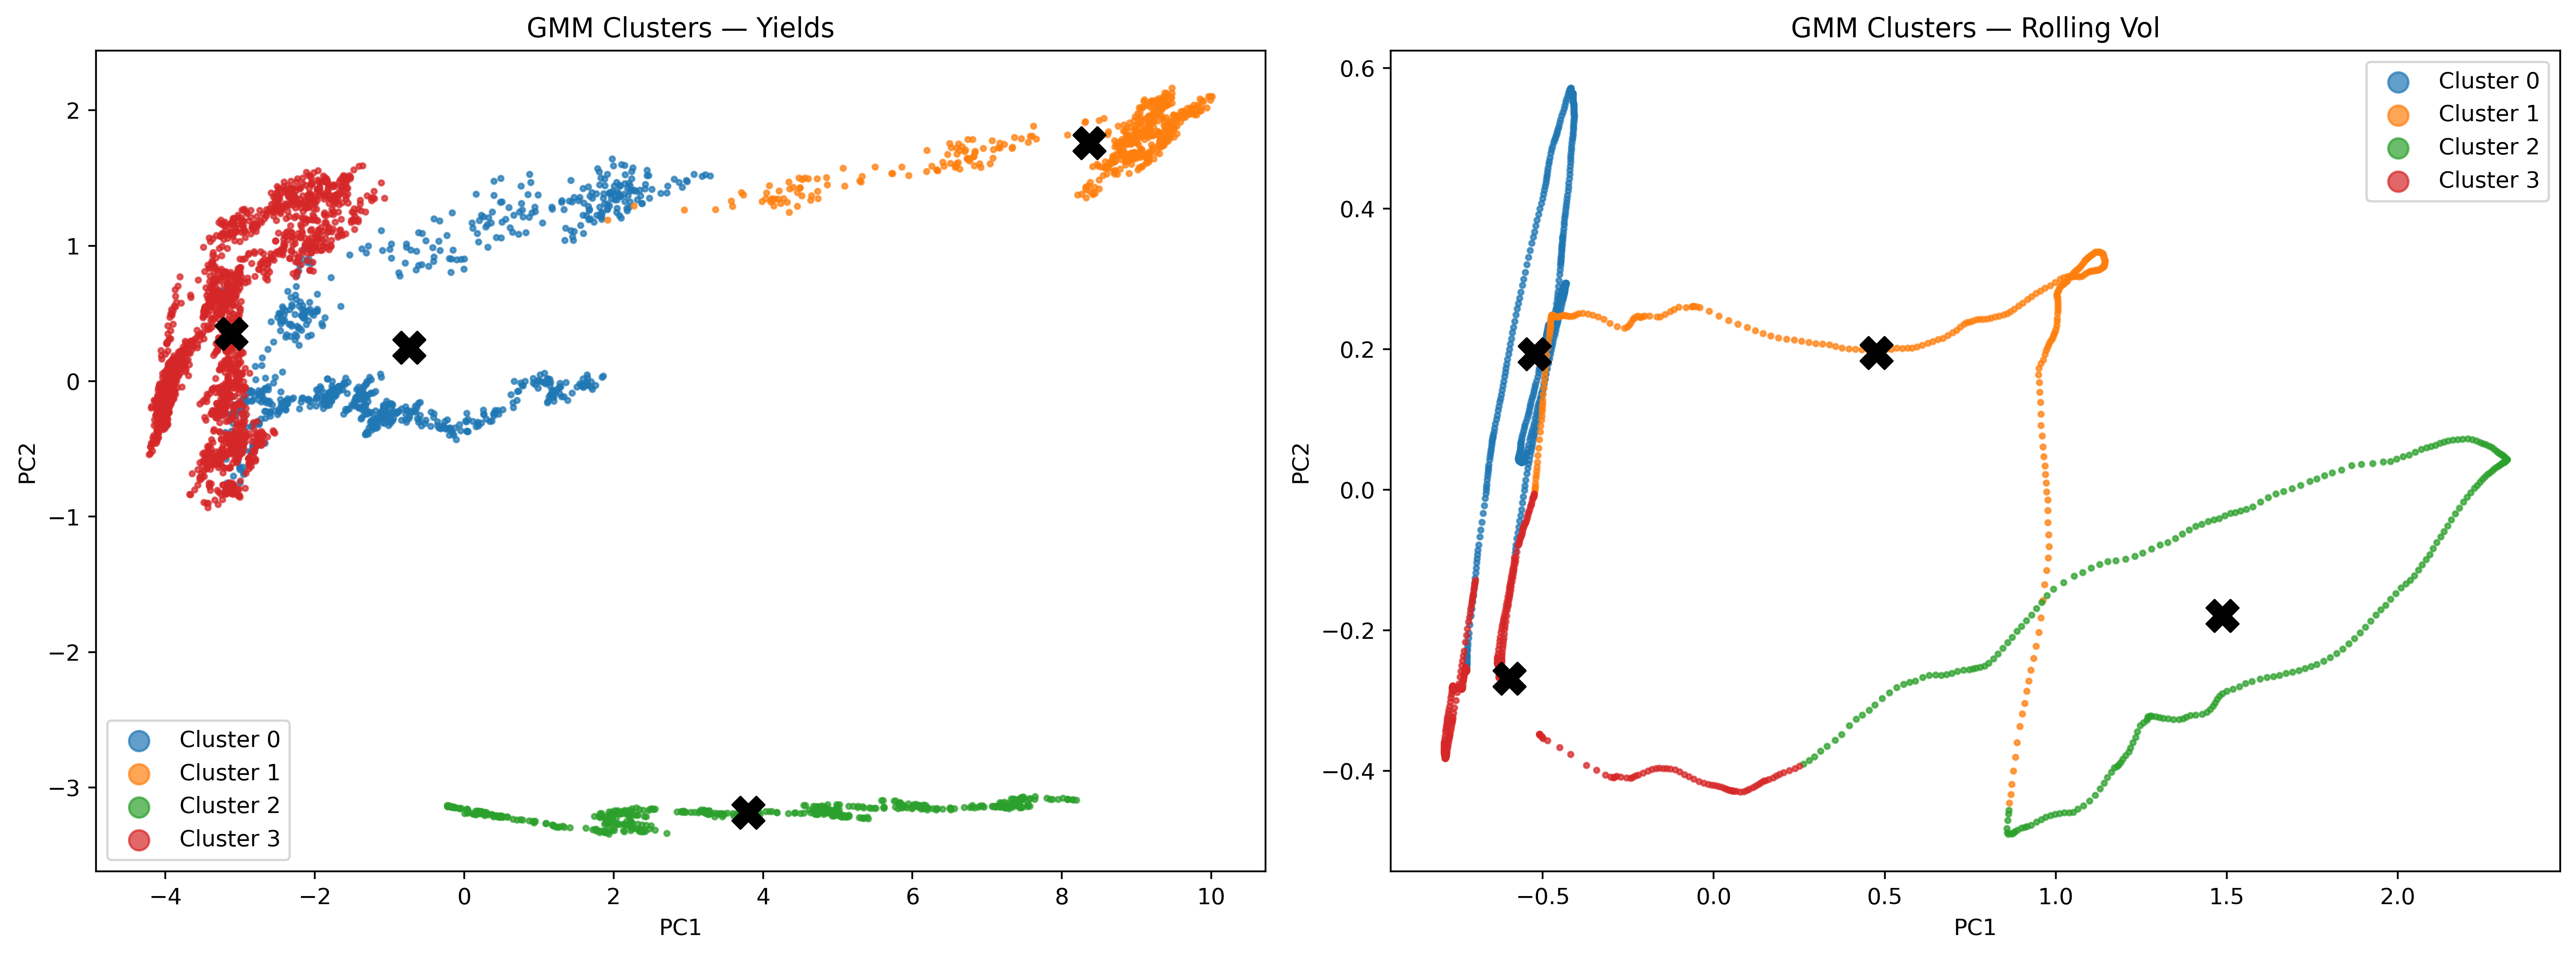

In [93]:
from sklearn.mixture import GaussianMixture

N_CLUSTERS = 4

yields_gmm = GaussianMixture(n_components=N_CLUSTERS, random_state=42).fit(yields_X)
yields_labels = yields_gmm.predict(yields_X)
yields_probs = yields_gmm.predict_proba(yields_X)

vol_gmm = GaussianMixture(n_components=N_CLUSTERS, random_state=42).fit(vol_X)
vol_labels = vol_gmm.predict(vol_X)
vol_probs = vol_gmm.predict_proba(vol_X)

fig, (ax_yields, ax_vol) = plt.subplots(1, 2, figsize=(16, 6))

for k in range(N_CLUSTERS):
    mask = yields_labels == k
    ax_yields.scatter(yields_scores[mask, 0], yields_scores[mask, 1], s=5, alpha=0.7, label=f"Cluster {k}")
yields_centers = yields_pca.transform(yields_gmm.means_)
ax_yields.scatter(yields_centers[:, 0], yields_centers[:, 1], marker='X', s=200, c='black', zorder=10)
ax_yields.set_xlabel("PC1")
ax_yields.set_ylabel("PC2")
ax_yields.set_title("GMM Clusters — Yields")
ax_yields.legend(markerscale=4)

for k in range(N_CLUSTERS):
    mask = vol_labels == k
    ax_vol.scatter(vol_scores[mask, 0], vol_scores[mask, 1], s=5, alpha=0.7, label=f"Cluster {k}")
vol_centers = vol_pca.transform(vol_gmm.means_)
ax_vol.scatter(vol_centers[:, 0], vol_centers[:, 1], marker='X', s=200, c='black', zorder=10)
ax_vol.set_xlabel("PC1")
ax_vol.set_ylabel("PC2")
ax_vol.set_title("GMM Clusters — Rolling Vol")
ax_vol.legend(markerscale=4)

plt.tight_layout()
plt.show()

We can see for the first time that the cluster centers are different. How we cluster, on what data we cluster makes a big difference. Clustering directly on volatility produces vastly different results then clustering directly on yields.

Can you think of some other ideas on how we can cluster the data points. 

## Duration and Convexity
- Duration neutral trades
- Convexity neutral trades

- What is the importance of duration and convexity when hedging a position?

## Spreads
- What statistical property do they follow?
- Can you formalise with any specific form of statistic test?